In [49]:
import csv
import random
import numpy
import pandas as pd
import math
import time
from IPython.display import Audio, display
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import os

def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
    
motifs = (numpy.genfromtxt('very_popular_motifs.csv',dtype='U'))
fams = (numpy.genfromtxt('very_popular_fams.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('very_popular_motifxFamMatrix.csv',delimiter=',',dtype=int)

print (motifxFamMatrix.shape)

(6720, 13)


In [2]:
n_grams_ = numpy.genfromtxt('data/protVec_100d_3grams.csv',dtype='U')[:,0]
coords_matrix_ = numpy.genfromtxt('data/protVec_100d_3grams.csv',dtype=float)[:,1:]

n_grams_to_coords = {}
n_grams = []
coords_matrix = []
for i, gram in enumerate(n_grams_):
    n_grams_to_coords[gram] = coords_matrix_[i]
    n_grams.append(gram)
    coords_matrix.append(coords_matrix_[i])
    
coords_matrix = numpy.array(coords_matrix,dtype=float)
n_grams = numpy.array(n_grams,dtype='U')
print (coords_matrix.shape)
print (n_grams.shape)

aaDict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
              'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
              'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
              'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
aaSingles = [v for v in aaDict.values()]+["X"]

amino_acids = numpy.array([x for x in aaDict.values()])


coords_amino_acids = {aa:[] for aa in amino_acids}
for gram,coords in n_grams_to_coords.items():
    for aa in amino_acids:
        if aa in gram: 
            coords_amino_acids[aa].append(coords)
            
for k,v in coords_amino_acids.items():
    avgCoords = [numpy.mean(numpy.array([v[j][i] for j in range(len(v))]) ) for i in range(100)]
    coords_amino_acids[k] = avgCoords
    
coords_amino_acids_matrix = numpy.array([x for x in coords_amino_acids.values()],dtype=float)


motif_embedding = numpy.zeros((motifs.shape[0],3600)) # popular_motifs / motifs

for i,motif in enumerate(motifs): # popular_motifs / motifs
    embedding = []
    for j in range(13):
        n_gram = motif[j:j+3]
        embedding.extend(n_grams_to_coords[n_gram])
    for j in range(12):
        n_gram = motif[j+1:j+4]
        embedding.extend(n_grams_to_coords[n_gram])
    for j in range(11):
        n_gram = motif[j+2:j+5]
        embedding.extend(n_grams_to_coords[n_gram])
    embedding = numpy.array(embedding)
    motif_embedding[i,:] = embedding
print (motif_embedding.shape)


pos_charLevel = []
for motif in motifs:
    pos = [coords_amino_acids[aa] for aa in motif]
    pos_charLevel.append(pos)
pos_charLevel = numpy.array(pos_charLevel,dtype=float)
print (pos_charLevel.shape)

pos_charLevel = pos_charLevel.reshape(pos_charLevel.shape[0],pos_charLevel.shape[1]*pos_charLevel.shape[2])
print (pos_charLevel.shape)

(9048, 100)
(9048,)
(6720, 3600)
(6720, 15, 100)
(6720, 1500)


In [3]:
import umap.umap_ as umap
import time

umapper = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(pos_charLevel)
print ("secs: %5.3f" % (time.time()-s))
allDone()

secs: 72.279


In [198]:
fave_fams = ['Src','MAPK','CK2','PIKK','PKA']

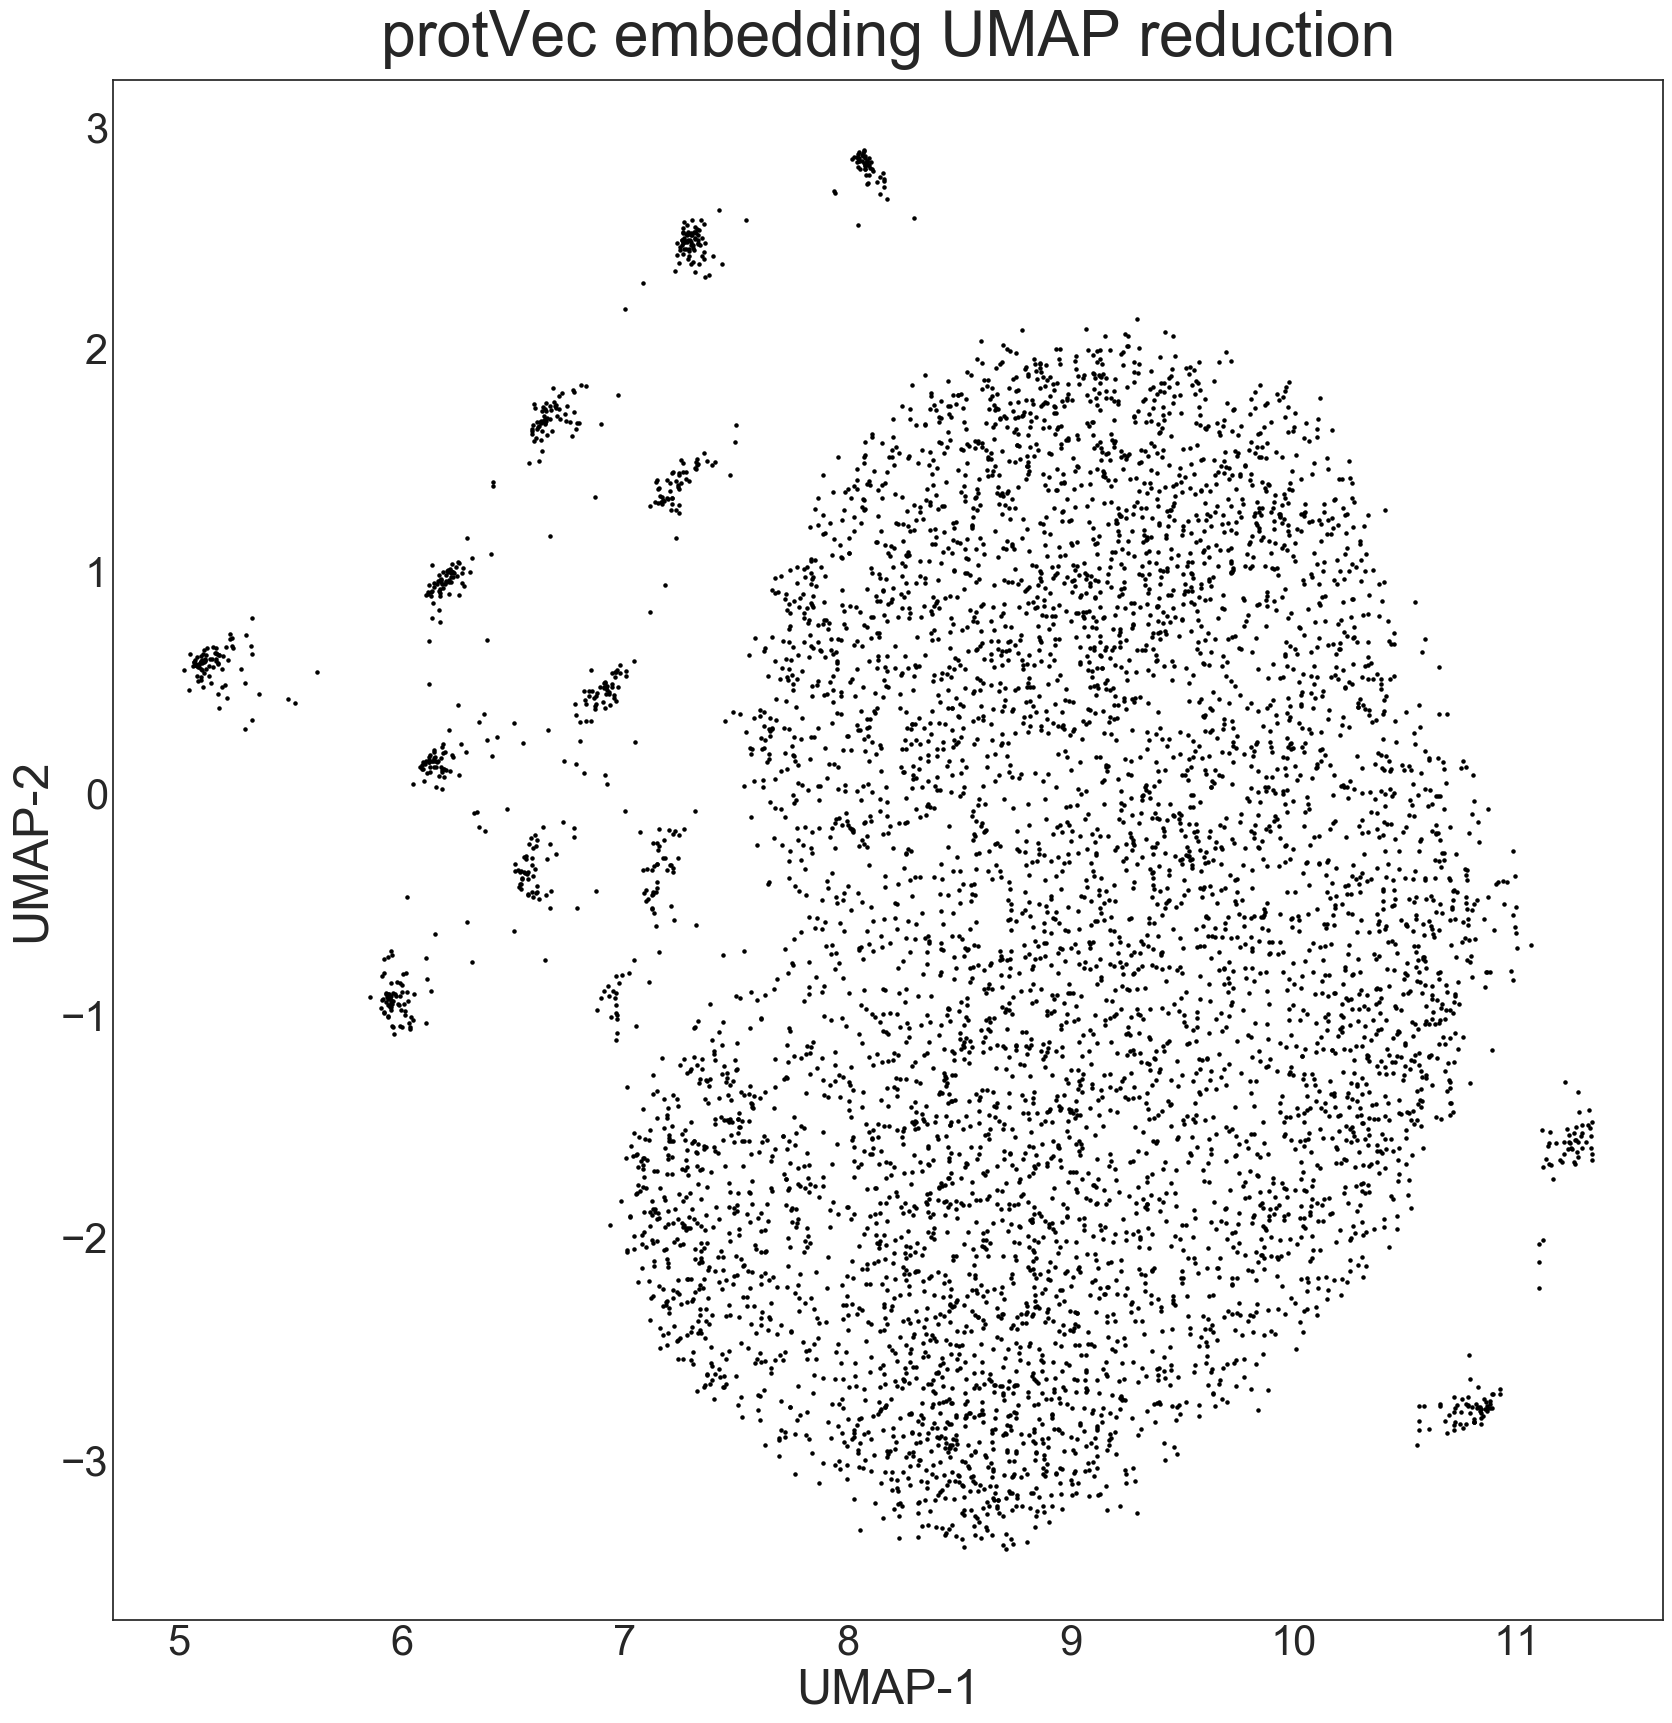

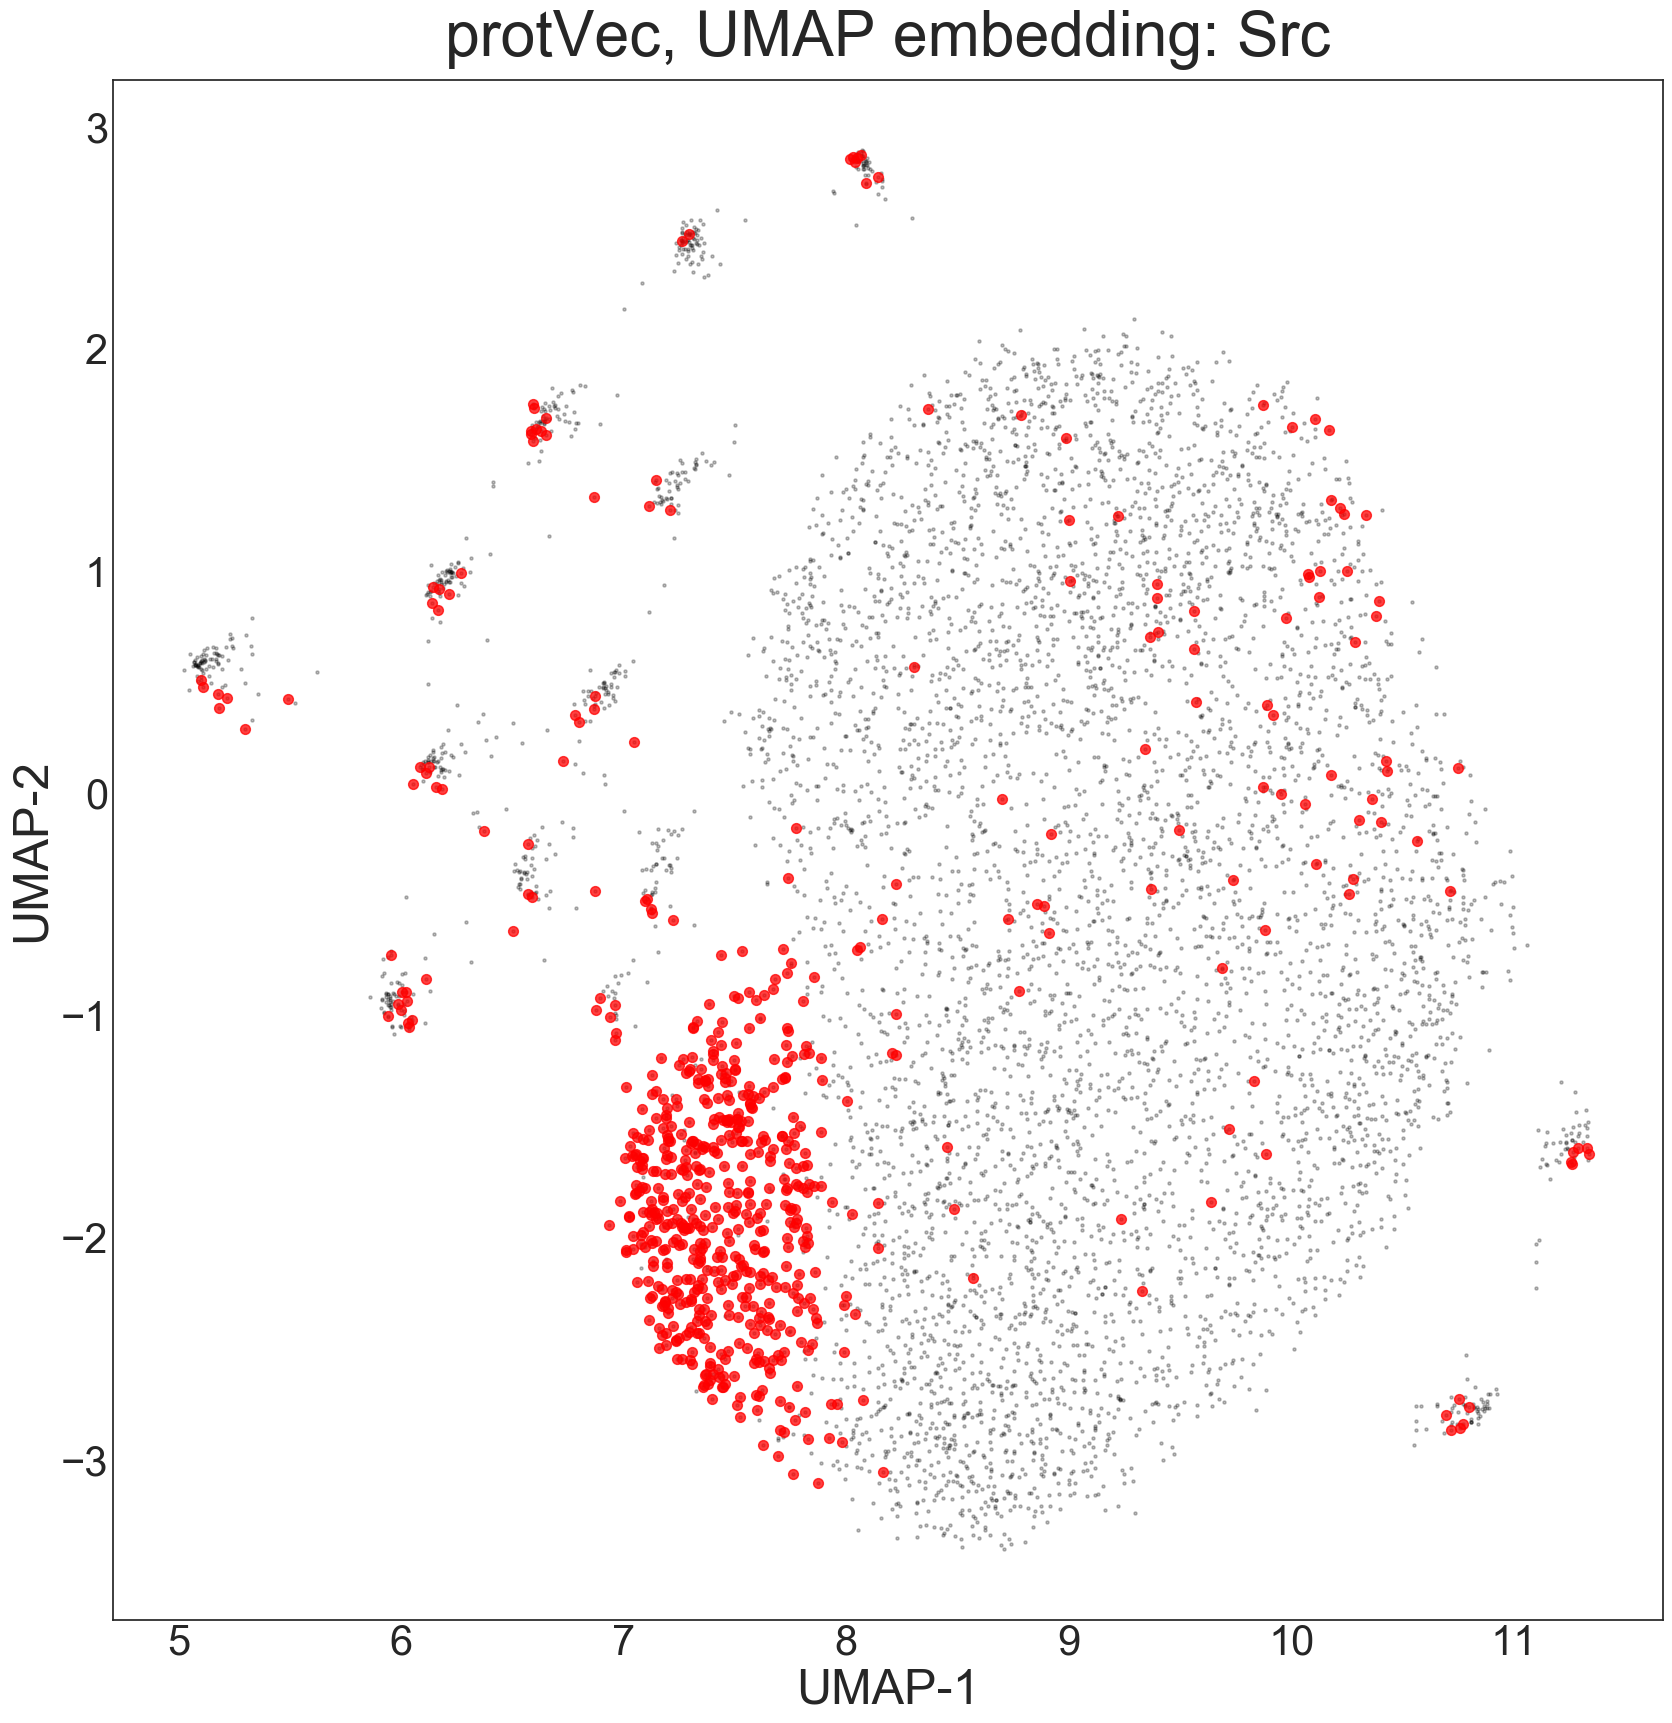

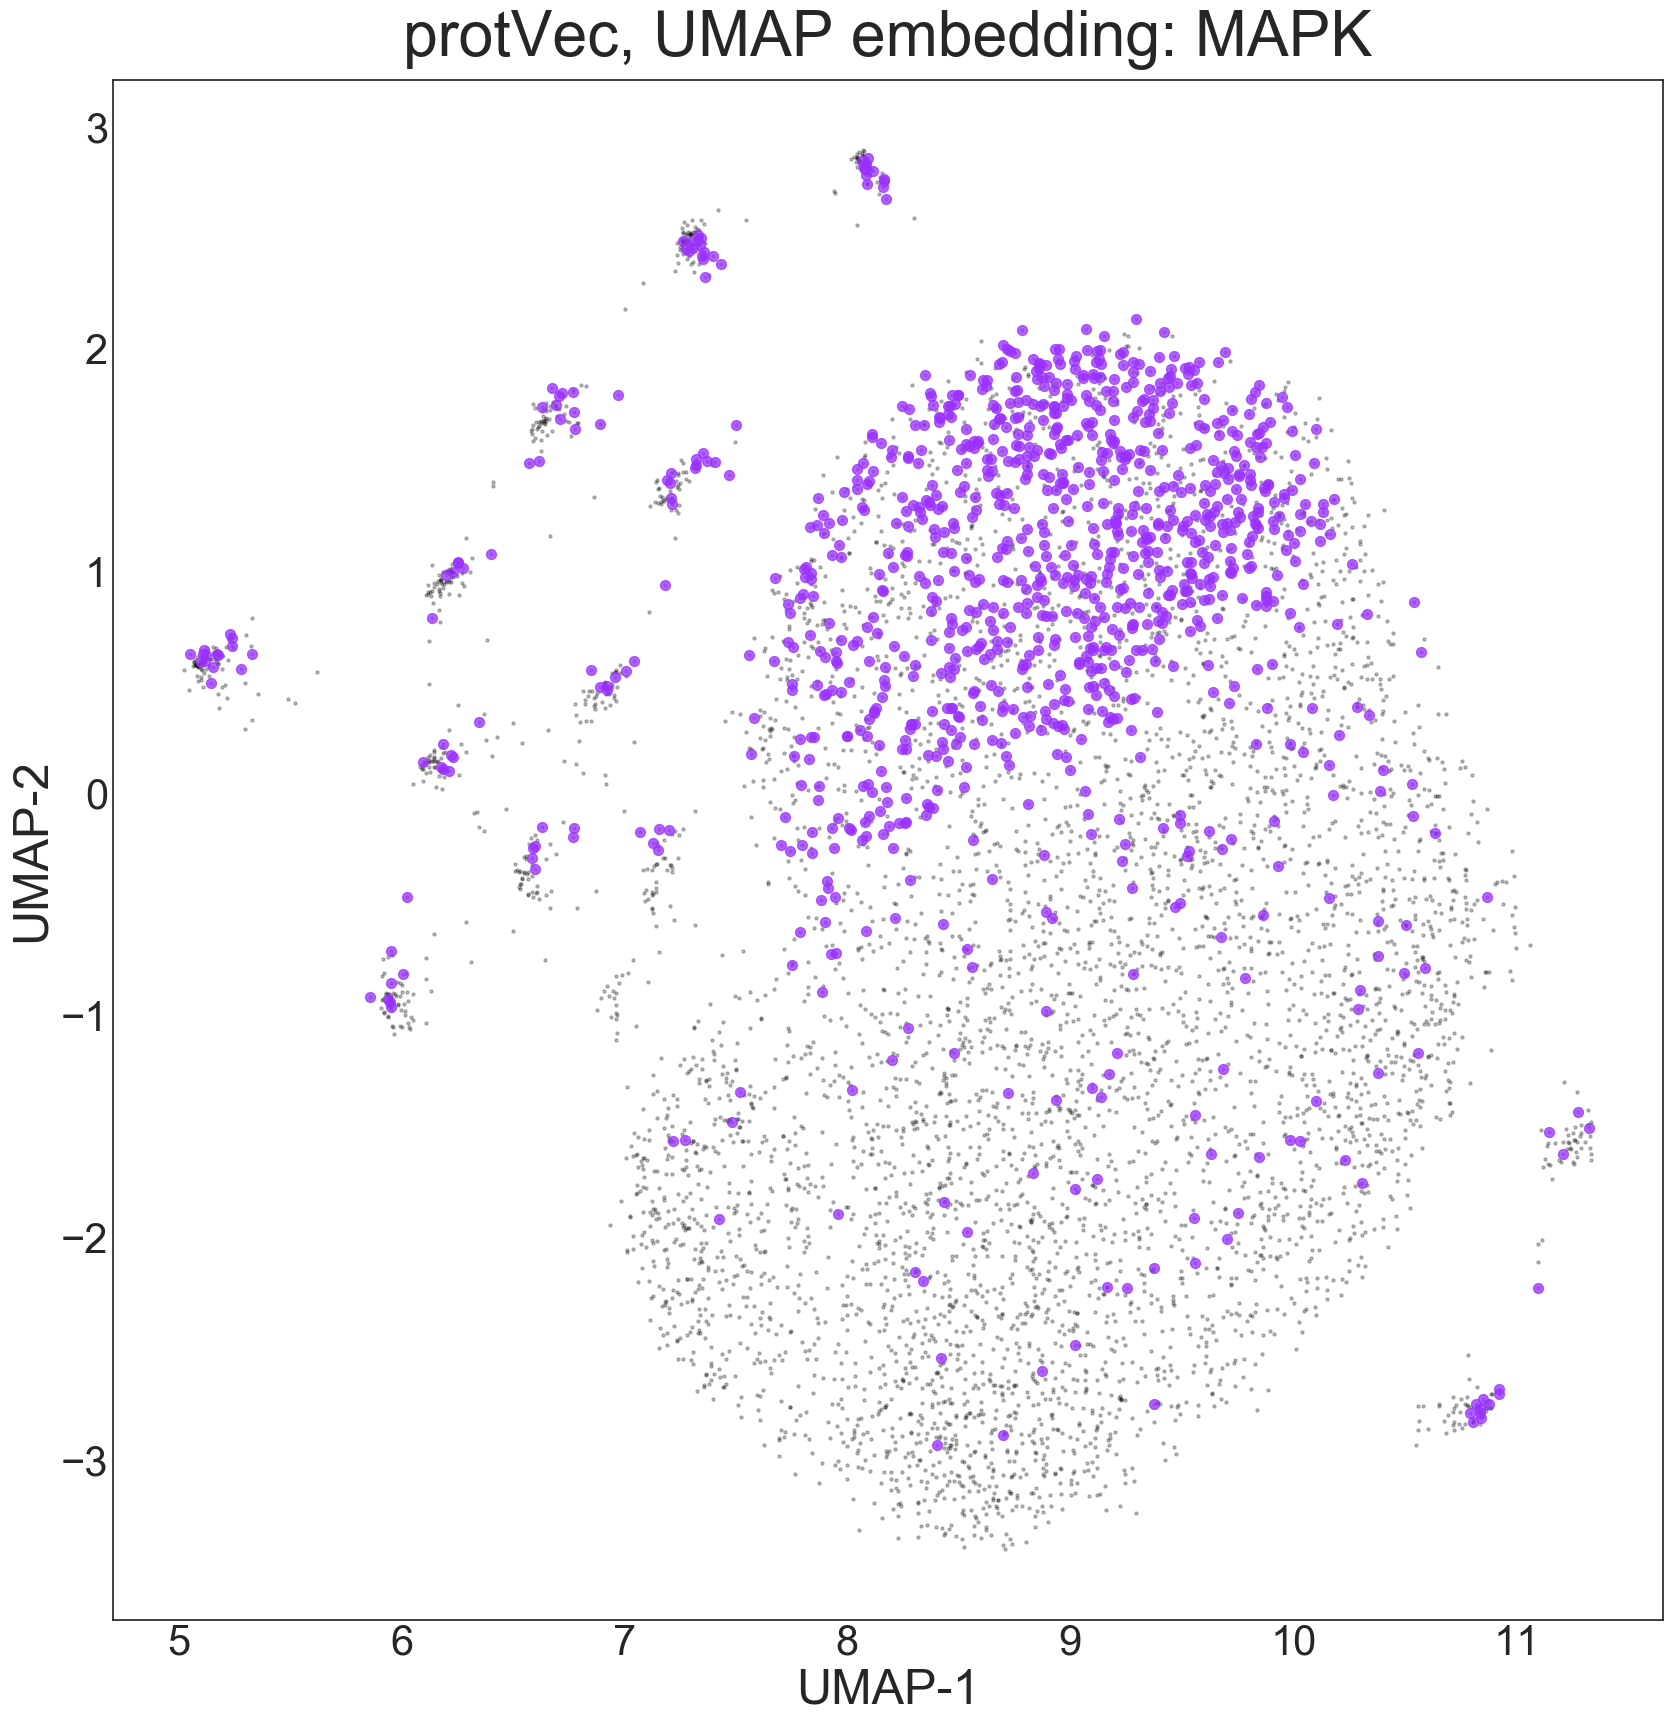

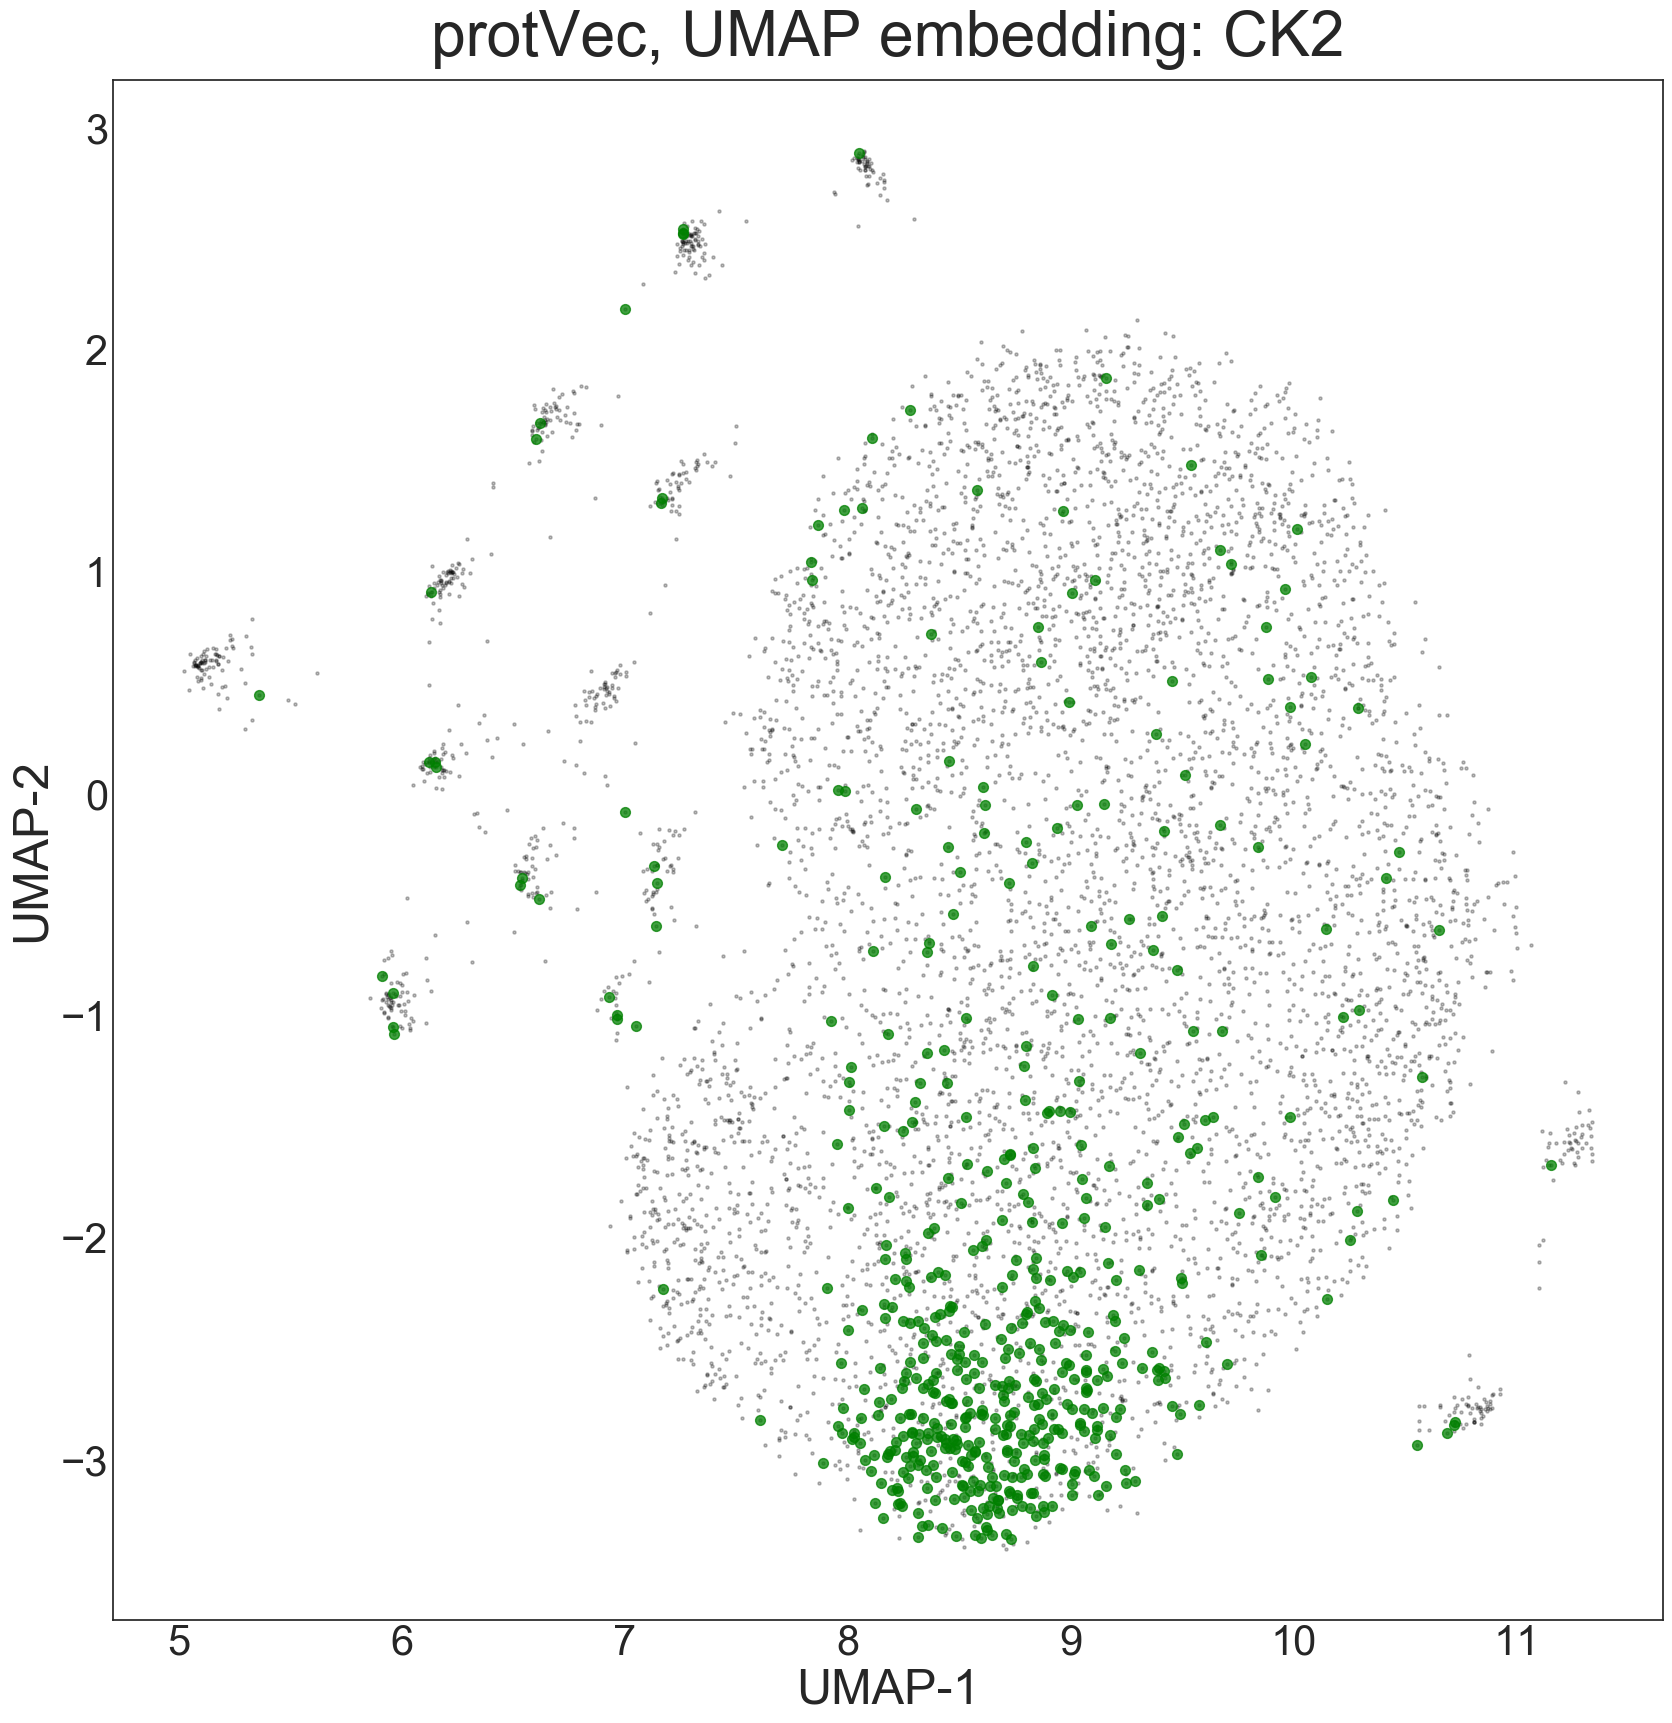

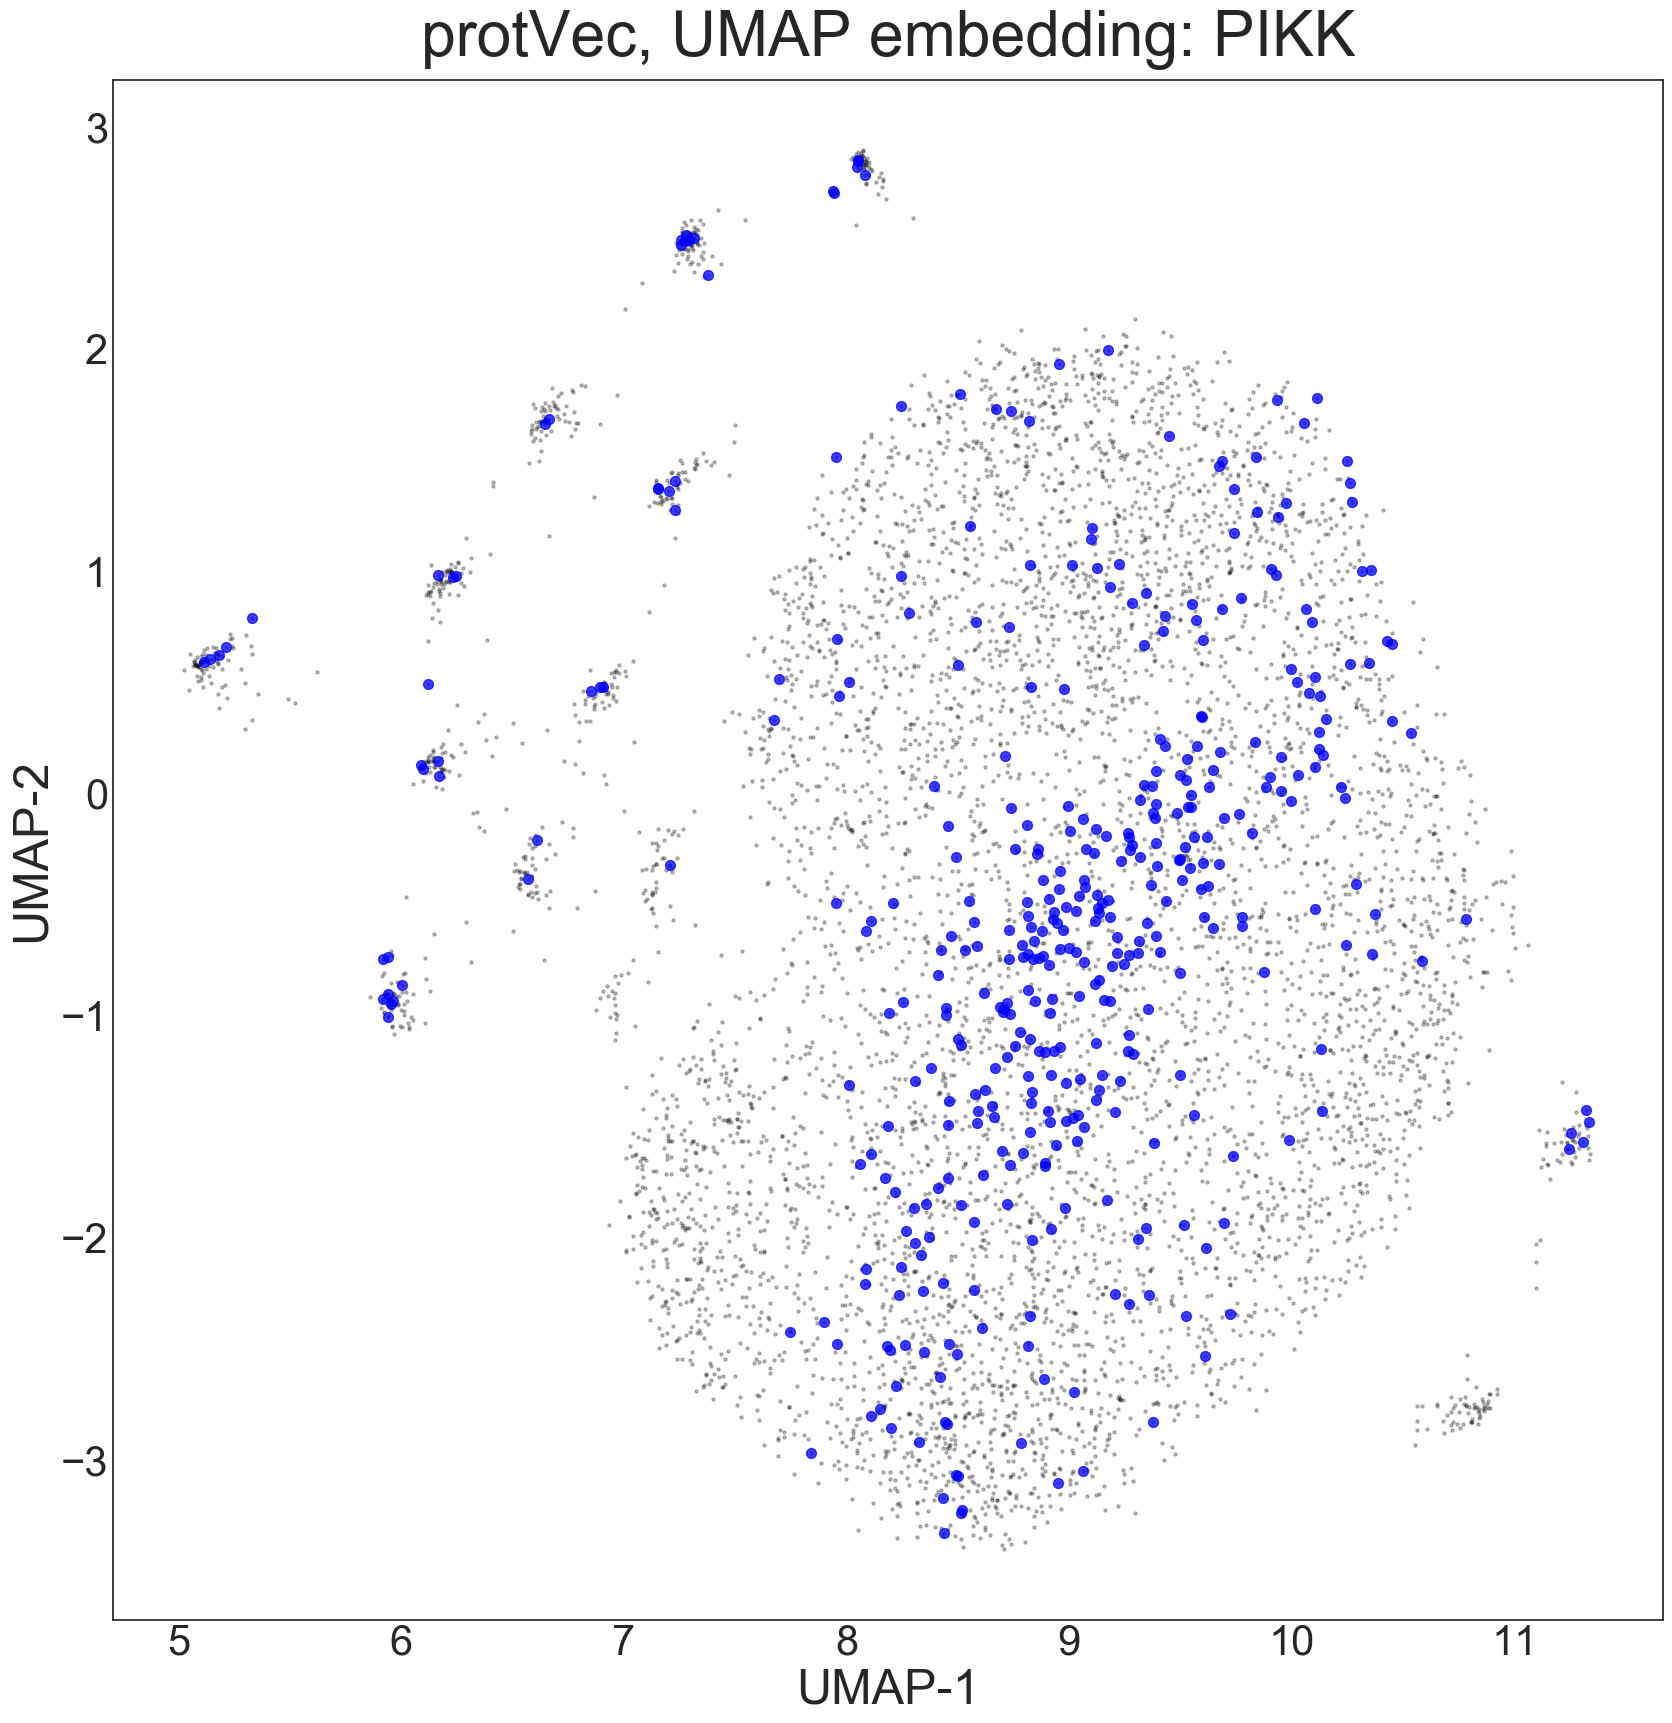

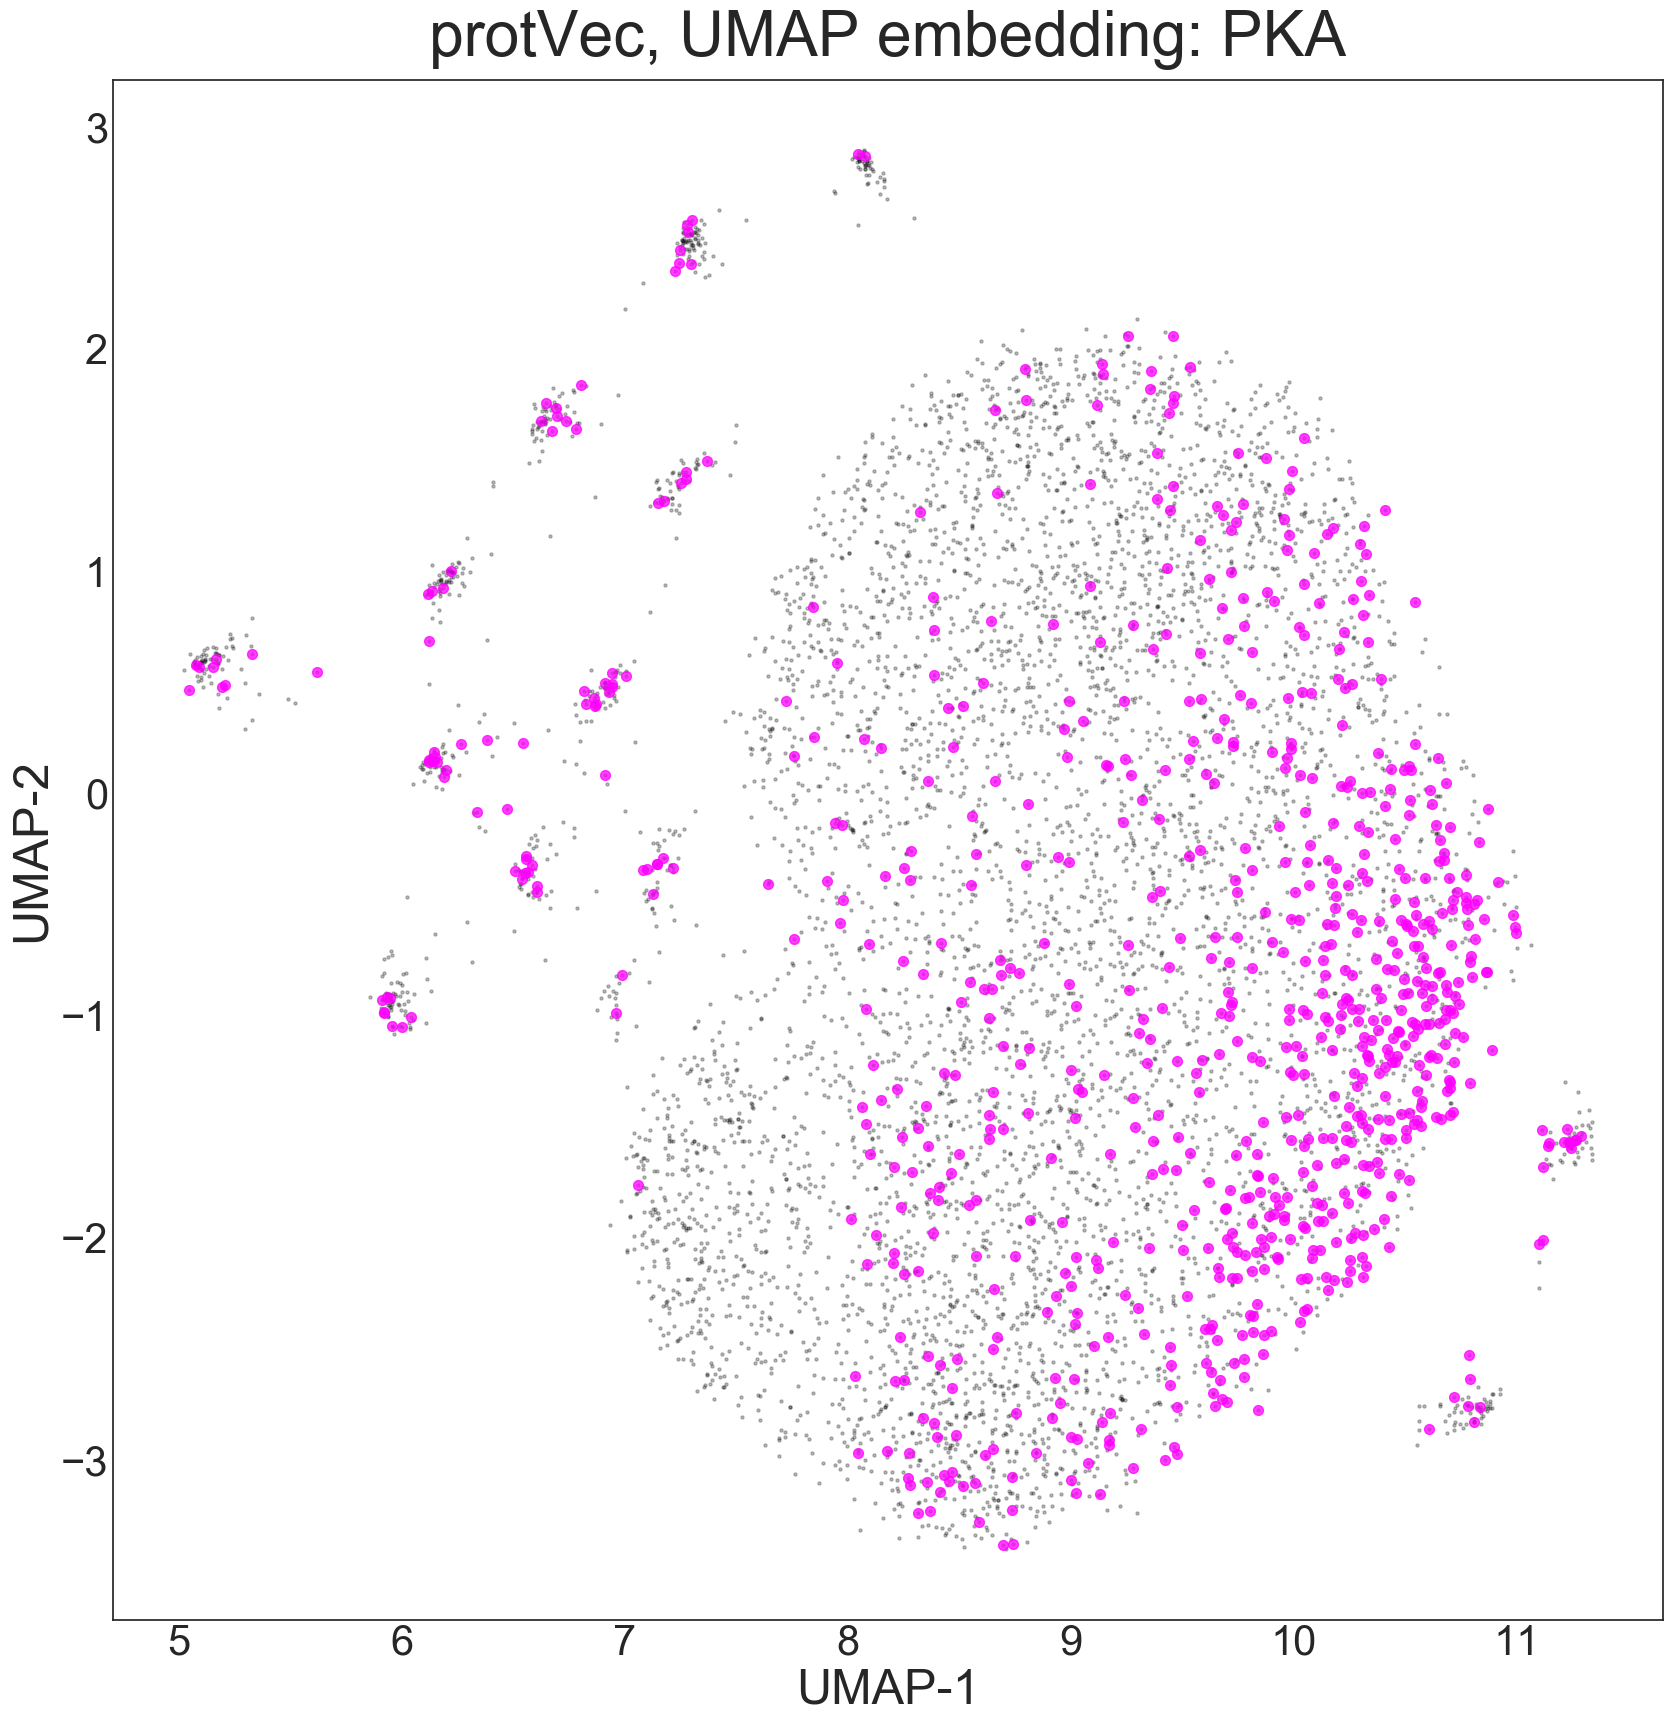

In [205]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# colors = ['red','coral','sandybrown','orange','gold','lawngreen','limegreen','turquoise','deepskyblue','blue','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']
colors = ['red', '#9B30FF', 'green', 'blue', 'magenta']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)

plt.title("protVec embedding UMAP reduction",fontsize=45,y=1.01)
plt.xlabel("UMAP-1",fontsize=35)

plt.ylabel("UMAP-2",fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# plt.savefig("pooooo/protVec_2d_noHighlights")
plt.show()

i = -1
for fam in fave_fams:
    i += 1
    fIdx = numpy.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("protVec, UMAP embedding: %s" % fam),fontsize=45,y=1.01)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("UMAP-1",fontsize=35)

    plt.ylabel("UMAP-2",fontsize=35)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black',alpha=0.25)
    color = colors [i]
    for motifIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if motifxFamMatrix[motifIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=50,c=color,alpha=0.75)          
#     plt.show()
    plt.savefig(("protVecFaves/protVec_fave_%s" % fam))

In [40]:
random.seed(46)

idc = (numpy.arange(len(motifs)))
random.shuffle(idc)
trainAndTestSets = []

trainSetSize = int(len(motifs) * .8)
testSetSize = int(len(motifs) * .2)

for i in range(5):
    s = i * testSetSize
    e = i * testSetSize + testSetSize
    testIdc = idc[s:e]
    
    trainIdc = [x for x in idc if x not in testIdc] 
    trainAndTestSets.append( [trainIdc,testIdc] )

In [152]:
len(motifs)*.05

336.0

In [183]:
def kNNOneFold(embed, trainIdc, testIdc, confusion, thresh, neighbors=20):
    
    X_train = embed[trainIdc]
    x_test = embed[testIdc]
    Y_train = motifxFamMatrix[trainIdc]
    y_test = motifxFamMatrix[testIdc]
    
    # Run kNN
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    result = knn.fit(X_train, Y_train)

    knnProbs = knn.predict_proba(x_test)

    y_score = []
    for samp in knnProbs:
        y_score.append([prob[1] for prob in samp])
    y_score = numpy.array(y_score).T   
    
    for i,mIdx in enumerate(testIdc):
        true_fIdc = numpy.where( motifxFamMatrix[mIdx]==1 )[0]
        pred_fIdc = numpy.where( y_score[i] >= thresh )[0]

        for pred_fIdx in pred_fIdc:
            for true_fIdx in true_fIdc:
                confusion[pred_fIdx][true_fIdx] += 1
    
    return (confusion, y_score, y_test)

In [184]:
confusion = numpy.zeros((len(fams), len(fams)))
all_y_score = []
all_y_test = []

for p,idcPair in enumerate(trainAndTestSets):
    p+=1
    print ("------------------------------------ SET: %s ------------------------------------" % p)
    
    myTrainIdc = idcPair[0]
    myTestIdc = idcPair[1]
    
    confusion, y_score, y_test = kNNOneFold(pos_charLevel, myTrainIdc, myTestIdc, confusion, thresh=0.25,neighbors=67)
    all_y_score.append(y_score)
    all_y_test.append(y_test)

------------------------------------ SET: 1 ------------------------------------
------------------------------------ SET: 2 ------------------------------------
------------------------------------ SET: 3 ------------------------------------
------------------------------------ SET: 4 ------------------------------------
------------------------------------ SET: 5 ------------------------------------


In [185]:
allDone()

In [187]:
import math 
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0.0000001

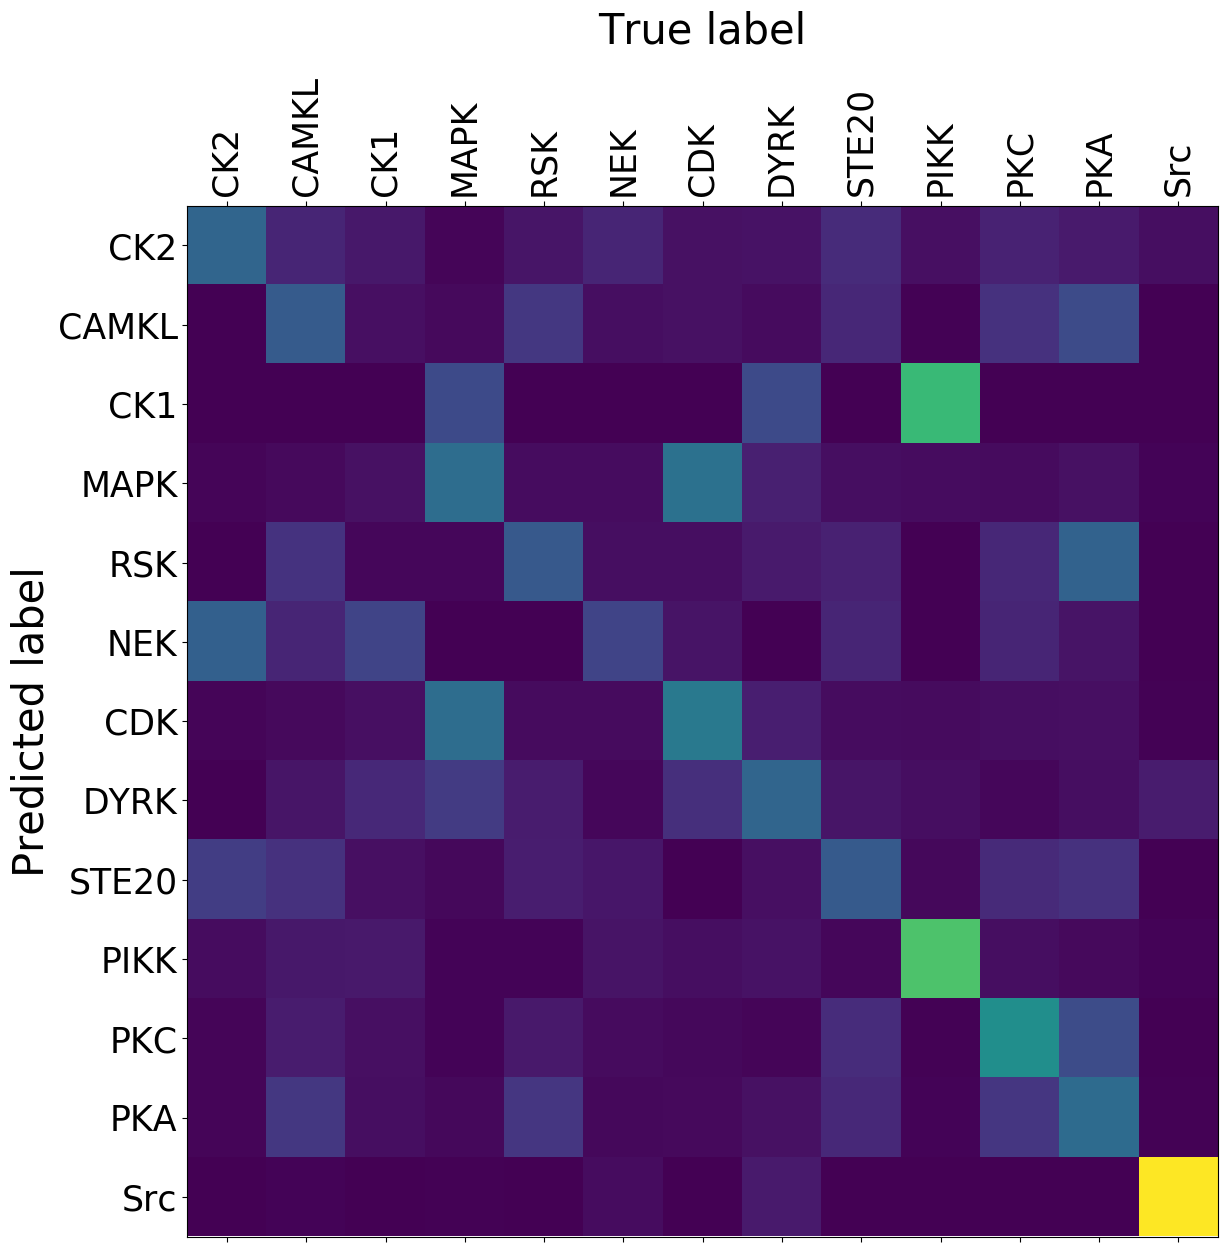

In [188]:
import matplotlib.ticker as ticker

# Normalize by dividing every row by its sum
plt.style.use('default')
for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0

# Set up plot
fig = plt.figure(figsize=(12.5,12.5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
# fig.colorbar(cax)

# Set up axes
fs = [x for x in fams]
ax.set_xticklabels([''] + fs, rotation=90)
ax.set_yticklabels([''] + fs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.title("True label",fontsize=30,y=1.15)
plt.ylabel("Predicted label",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("bbbb")


# sphinx_gallery_thumbnail_number = 2
plt.show()

In [189]:
y_test = []
for res in all_y_test:
    y_test.extend([x for x in res])

y_test = numpy.array(y_test)

y_score = []
for res in all_y_score:
    y_score.extend([x for x in res])

y_score = numpy.array(y_score)

In [190]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.42


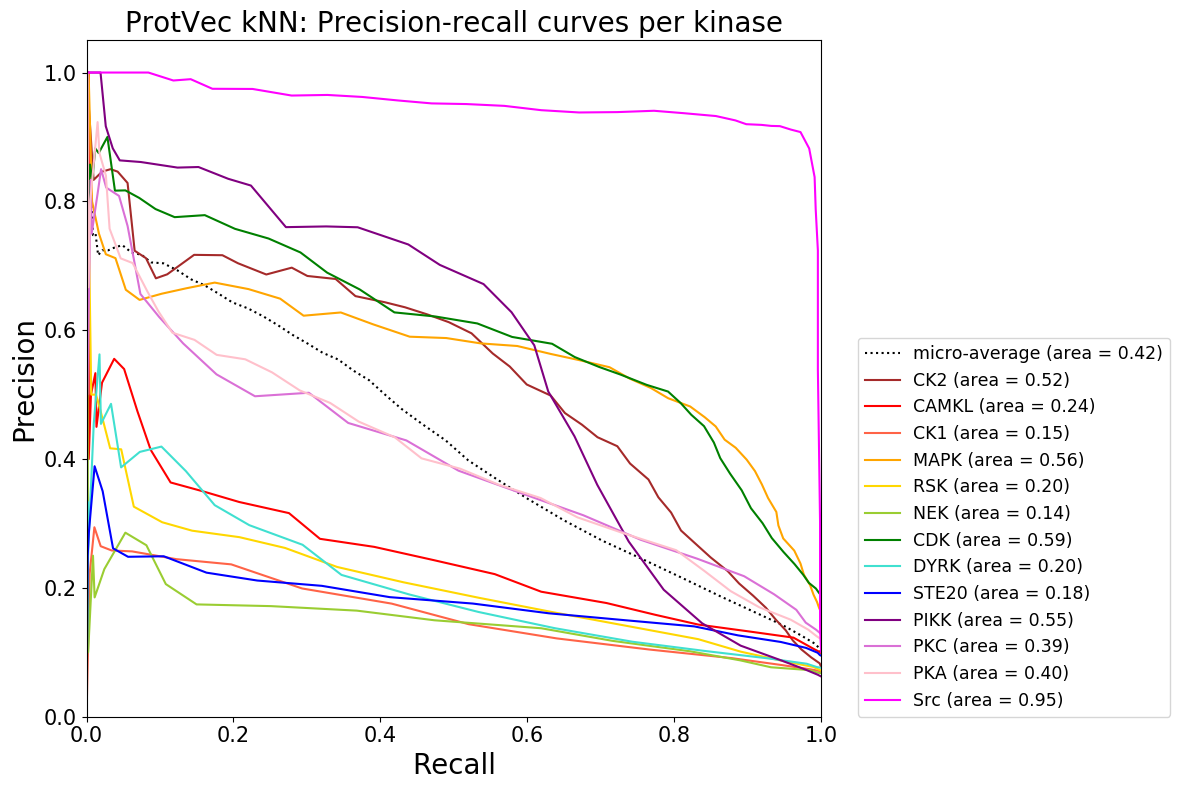

In [191]:
from itertools import cycle
import numpy as np
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
               'purple','pink','orchid']) 

colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

plt.figure(figsize=(12, 8))
f_scores = numpy.linspace(0.2, 0.8, num=4)
lines = []
labels = []

l, = plt.plot(recall["micro"], precision["micro"], color='black', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(fclass, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ProtVec kNN: Precision-recall curves per kinase',fontsize=20)
plt.legend(lines, labels, loc=(1.05, 0), fontsize=12.5)
plt.tight_layout()
plt.savefig("poo")

plt.show()

In [192]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

FAM_IDC = range(len(fams))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

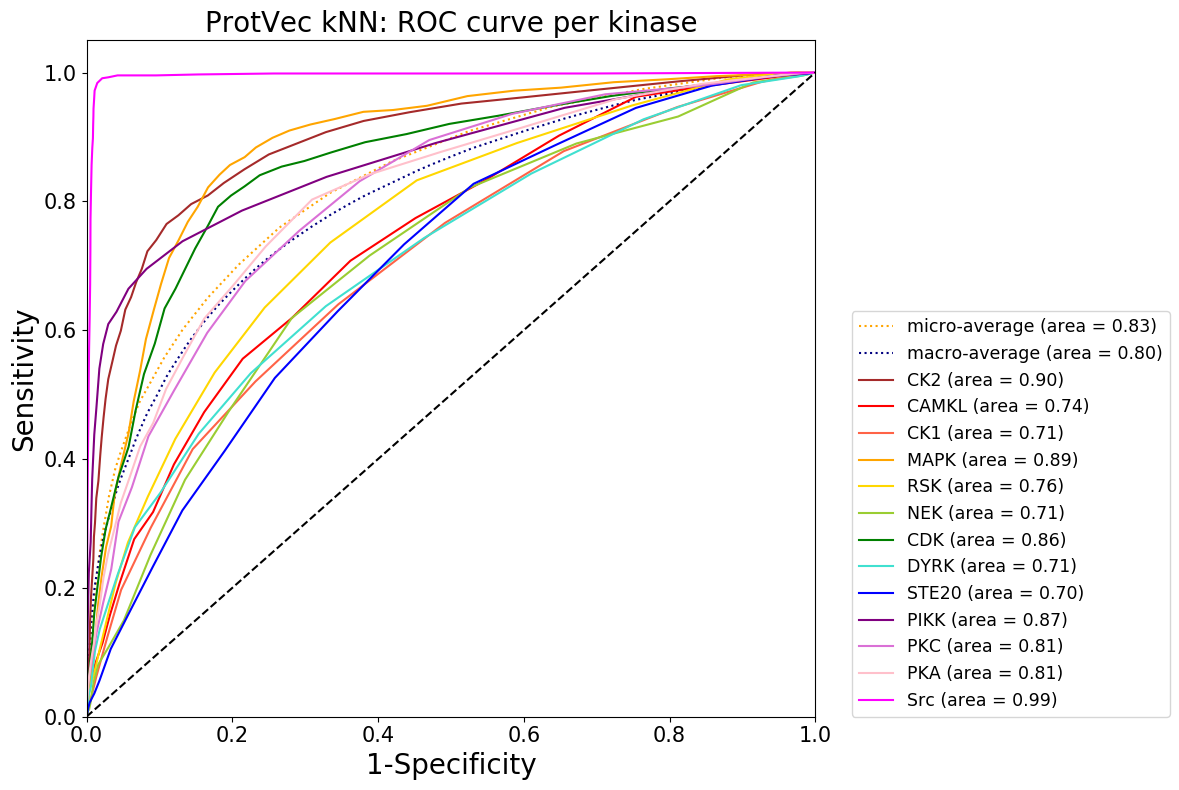

In [193]:
# Plot all ROC curves


lw = 1.5
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

for i, color in zip( (FAM_IDC), colors):
    fam = fams[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(fam, roc_auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ProtVec kNN: ROC curve per kinase',fontsize=20)
plt.legend(loc=(1.05, 0),fontsize=12.5)
plt.tight_layout()


# plt.savefig('fams_Stat_figs/RNN_ROC_select_testData_200OrMoreMotifs', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig("POOP")
plt.show()

In [194]:
confusion_numpy = confusion
FP = confusion_numpy.sum(axis=0) - np.diag(confusion_numpy)  
FN = confusion_numpy.sum(axis=1) - np.diag(confusion_numpy)
TP = np.diag(confusion_numpy)
TN = confusion_numpy.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print ("TPR:",numpy.mean(TPR))
print ("TNR:",numpy.mean(TNR)) 
print ("PPV:",numpy.mean(PPV)) 
print ("NPV:",numpy.mean(NPV)) 
print ("FPR:",numpy.mean(FPR)) 
print ("FNR:",numpy.mean(FNR)) 
print ("FDR:",numpy.mean(FDR)) 
print ("ACC:",numpy.mean(ACC)) 

TPR: 0.34293720186014287
TNR: 0.9452447668216786
PPV: 0.331172454345493
NPV: 0.9454093745754011
FPR: 0.05475523317832143
FNR: 0.657062798139857
FDR: 0.6688275456545069
ACC: 0.8989134156707911


In [207]:
pos_charLevel.shape

(6720, 1500)

In [206]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [322]:
import numpy as np 

fam_counts = []
for fIdx,fam in enumerate(motifxFamMatrix.T):
    print (fams[fIdx],numpy.sum(motifxFamMatrix.T[fIdx]))
    fam_counts.append(numpy.sum(motifxFamMatrix.T[fIdx]))
fam_counts = numpy.array(fam_counts)

normalized_fam_counts = fam_counts / np.sqrt(np.sum(fam_counts**2))

for i in range(len(normalized_fam_counts)):
    normalized_fam_counts[i] = 1-normalized_fam_counts[i]
normalized_fam_counts = np.array(normalized_fam_counts) 
normalized_fam_counts = torch.from_numpy( np.array(normalized_fam_counts)) 
normalized_fam_counts = normalized_fam_counts.double()

CK2 519
CAMKL 664
CK1 467
MAPK 1066
RSK 466
NEK 454
CDK 1267
DYRK 510
STE20 637
PIKK 420
PKC 859
PKA 796
Src 677


In [323]:
def famGuessFromMotifCoords(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return fams[category_i], category_i

def multipleFamGuessesFromMotifCoords(output, thresh=0.5):
    out = output.detach().numpy()
    pred_fIdc = numpy.where(out >= thresh)[0]
    return (pred_fIdc)

In [324]:
def getBatch(idc, BATCH_SIZE):
    
    mIdx_batch = []
    fam_batch = []
    num_of_samps_in_batch = 0

    for i in range (BATCH_SIZE):

        mIdx = random.choice(idc) 
        motif_coords = pos_charLevel[mIdx]
        mIdx_batch.append(torch.tensor(motif_coords).float())   
        
        fIdx = numpy.where(motifxFamMatrix[mIdx]==1)[0]
        fam_tensor = numpy.zeros(len(fams))
        
        for j,val in enumerate(fam_tensor):
            if j in fIdx:
                fam_tensor[j] = 1

        fam_batch.append(torch.tensor(fam_tensor).double())

    
    mIdx_batch = torch.stack(mIdx_batch)
    fam_batch = torch.stack(fam_batch)
            
    return (mIdx_batch, fam_batch)

In [325]:
def testOneFold(model, testIdc, confusion, thresh):
    
    BATCH_SIZE = len(testIdc)
    mIdx_batch, fam_batch = getBatch(testIdc, BATCH_SIZE)
    out = model(mIdx_batch)
    score = 0
    for i,mIdx in enumerate(mIdx_batch):
        fam = fam_batch[i].detach().numpy()
        myFams = numpy.where( fam==1 )[0]
        pred_fam = famGuessFromMotifCoords(out[i])[0]
        if pred_fam in [fams[x] for x in myFams]:
            score+=1

    accuracy = score / BATCH_SIZE
    print("Test accuracy:",accuracy,"\n")
    
    ############################################

    IDC = testIdc

    BATCH_SIZE = len(IDC)
    mIdx_batch, fam_batch = getBatch(IDC, BATCH_SIZE)
    output = model(mIdx_batch).double() # UGH. changed to double . . . .

    for i,mIdx in enumerate(IDC):
        fam = fam_batch[i].detach().numpy()
        true_fIdc = numpy.where( fam==1 )[0]
        pred_fIdc = multipleFamGuessesFromMotifCoords(output[i], thresh)

        for pred_fIdx in pred_fIdc:
            for true_fIdx in true_fIdc:
                confusion[pred_fIdx][true_fIdx] += 1
                
    y_score = output.detach().numpy()
    y_test = numpy.array(fam_batch)

    return (accuracy, confusion, y_score, y_test)

In [326]:
def trainOneFold(model, trainIdc, num_epochs, BATCH_SIZE):
    
    loss_history = []
    acc_history = []
    
    s = 1
    for epoch in range(num_epochs):
        tot_loss = []
        for bIdx in range(250): #range(())):len(trainIdc) len(motifs) 
            optimizer.zero_grad()
            mIdx_batch, fam_batch = getBatch(trainIdc, BATCH_SIZE)
            output = model(mIdx_batch).double() # UGH. changed to double . . . .
    
            loss = criterion(output, fam_batch)
            tot_loss.append(loss)
            loss.backward()
            
            optimizer.step()
            
            if bIdx % 25 == 0 :
                print("Iter {}\nEpoch number {}\nCurrent loss {}".format(s,epoch+1, sum(tot_loss)/len(tot_loss) ))
                loss_history.append( sum(tot_loss)/len(tot_loss) )

                # ------ ACCURACY ON TRAINING SET -----
                mIdx_batch, fam_batch = getBatch(trainIdc, BATCH_SIZE)
                out = model(mIdx_batch)
                score = 0
                for i,mIdx in enumerate(mIdx_batch):
                    fam = fam_batch[i].detach().numpy()
                    myFams = numpy.where( fam==1 )[0]
                    pred_fam = famGuessFromMotifCoords(out[i])[0]
                    if i%10==0:
                        print (pred_fam, [fams[x] for x in myFams])
                    if pred_fam in [fams[x] for x in myFams]:
                        score+=1
                accuracy = score / BATCH_SIZE
                acc_history.append(accuracy)
                print("Accuracy:",accuracy,"\n")

            s+=1
            
    return (loss_history, acc_history)

In [455]:
import torch
import torch.nn as nn

INPUT_DIM = pos_charLevel.shape[1]
HIDDEN_DIM_1 = 75
OUT_DIM = len(fams)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.hidden1 = nn.Linear(INPUT_DIM, HIDDEN_DIM_1)
        self.output = nn.Linear(HIDDEN_DIM_1, OUT_DIM)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, coords): 
        hidden1 = self.hidden1( coords ) 
        output = self.output( hidden1 )
        output = self.softmax( output )
        return output # WORKS BETTER WITH SOFTMAX !!!

In [468]:
all_losses = []
all_acc_history = []

all_accuracy = []
confusion = torch.zeros(len(fams), len(fams))
all_y_score = []
all_y_test = []

for p,idcPair in enumerate(trainAndTestSets):
    p+=1
    print ("------------------------------------ SET: %s ------------------------------------" % p)
    myModel = Model() 
    criterion = nn.BCEWithLogitsLoss(pos_weight=normalized_fam_counts)
    optimizer = optim.Adam(myModel.parameters(),lr = 0.005 )
    
    myTrainIdc = idcPair[0]
    myTestIdc = idcPair[1]
        
    (loss_history, acc_history) = trainOneFold(myModel, myTrainIdc, num_epochs=5, BATCH_SIZE=32)
    all_losses.append(loss_history)
    all_acc_history.append(acc_history)
    
    (accuracy, confusion, y_score, y_test) = testOneFold(myModel, myTestIdc, confusion, thresh=0.25)
    all_accuracy.append(accuracy)
    all_y_score.append(y_score)
    all_y_test.append(y_test)

------------------------------------ SET: 1 ------------------------------------
Iter 1
Epoch number 1
Current loss 0.7080835622026224
Src ['MAPK']
Src ['PIKK']
Src ['NEK', 'STE20']
Src ['PKA']
Accuracy: 0.0 

Iter 26
Epoch number 1
Current loss 0.7021263427264687
PKC ['RSK', 'STE20', 'PKC', 'PKA']
CDK ['NEK']
CDK ['MAPK']
Src ['CK2']
Accuracy: 0.15625 

Iter 51
Epoch number 1
Current loss 0.6992928405121003
MAPK ['MAPK']
CDK ['CDK']
Src ['Src']
CDK ['PKA']
Accuracy: 0.5 

Iter 76
Epoch number 1
Current loss 0.6972428777827439
Src ['Src']
MAPK ['MAPK']
CK2 ['CAMKL', 'DYRK']
CK2 ['CAMKL', 'NEK']
Accuracy: 0.53125 

Iter 101
Epoch number 1
Current loss 0.6955235632918726
PKC ['STE20']
MAPK ['MAPK']
CDK ['CDK']
CDK ['MAPK']
Accuracy: 0.375 

Iter 126
Epoch number 1
Current loss 0.6939944608104698
PKC ['STE20']
PKC ['DYRK']
CDK ['MAPK', 'DYRK']
CDK ['MAPK']
Accuracy: 0.4375 

Iter 151
Epoch number 1
Current loss 0.6930614824170863
MAPK ['MAPK', 'CDK']
Src ['DYRK']
PKA ['CAMKL']
PKA ['STE20

Iter 251
Epoch number 2
Current loss 0.6914578157838723
PKC ['RSK']
MAPK ['CK1', 'PKA']
Src ['Src']
CK2 ['CAMKL']
Accuracy: 0.59375 

Iter 276
Epoch number 2
Current loss 0.6828291577583213
PIKK ['CK1']
MAPK ['MAPK']
CK2 ['CK2']
PKC ['PKC']
Accuracy: 0.53125 

Iter 301
Epoch number 2
Current loss 0.6830516995434107
Src ['Src']
PKA ['CAMKL']
CDK ['MAPK']
CK2 ['PKC']
Accuracy: 0.375 

Iter 326
Epoch number 2
Current loss 0.6824678543798735
Src ['MAPK', 'Src']
PKA ['CK2']
CDK ['CDK']
PKA ['CK2']
Accuracy: 0.5625 

Iter 351
Epoch number 2
Current loss 0.6824214281938695
PKC ['CDK']
PKC ['PKC']
PKC ['CK1']
PKA ['PKA']
Accuracy: 0.625 

Iter 376
Epoch number 2
Current loss 0.6823482064865563
PKC ['RSK']
MAPK ['MAPK']
MAPK ['MAPK']
Src ['Src']
Accuracy: 0.4375 

Iter 401
Epoch number 2
Current loss 0.6821972235150542
Src ['Src']
PKA ['PKA']
PKA ['STE20']
CDK ['CDK']
Accuracy: 0.65625 

Iter 426
Epoch number 2
Current loss 0.6817784015116938
MAPK ['MAPK']
MAPK ['CDK']
CK2 ['NEK']
PKC ['RSK', '

Iter 551
Epoch number 3
Current loss 0.6794755740784805
CK2 ['CK2']
CK2 ['CK2']
CDK ['PKC']
CK1 ['CK1']
Accuracy: 0.625 

Iter 576
Epoch number 3
Current loss 0.6795272869365397
PKA ['RSK', 'NEK', 'PKA']
STE20 ['CDK']
PKC ['PKA']
STE20 ['NEK', 'DYRK']
Accuracy: 0.4375 

Iter 601
Epoch number 3
Current loss 0.6789803703137668
MAPK ['MAPK']
MAPK ['CDK']
CDK ['MAPK']
Src ['NEK', 'DYRK']
Accuracy: 0.65625 

Iter 626
Epoch number 3
Current loss 0.6788168311480401
RSK ['NEK']
CK2 ['CK1']
CAMKL ['CAMKL', 'RSK', 'PKA']
CDK ['CDK']
Accuracy: 0.59375 

Iter 651
Epoch number 3
Current loss 0.6789145957595789
Src ['NEK', 'Src']
CDK ['CDK']
CK1 ['CK2']
PKC ['PKC']
Accuracy: 0.71875 

Iter 676
Epoch number 3
Current loss 0.6789036589435169
Src ['Src']
DYRK ['CK1']
STE20 ['NEK', 'CDK', 'STE20']
STE20 ['CK1', 'STE20']
Accuracy: 0.59375 

Iter 701
Epoch number 3
Current loss 0.6791077238083579
PIKK ['CK1']
PKA ['CAMKL']
CK2 ['CK2']
CDK ['CDK']
Accuracy: 0.53125 

Iter 726
Epoch number 3
Current loss 0.

Iter 801
Epoch number 4
Current loss 0.6776669623173489
MAPK ['MAPK', 'CDK']
CK2 ['CK2']
PKC ['PKC']
CK2 ['CK2']
Accuracy: 0.6875 

Iter 826
Epoch number 4
Current loss 0.6781634986997706
PKA ['PKC']
MAPK ['MAPK']
PIKK ['CAMKL']
CDK ['MAPK', 'PKC']
Accuracy: 0.625 

Iter 851
Epoch number 4
Current loss 0.6787729056452511
CK2 ['CK2']
PIKK ['STE20']
DYRK ['CK1']
CDK ['CDK']
Accuracy: 0.5 

Iter 876
Epoch number 4
Current loss 0.678641706364219
Src ['Src']
PKC ['PKC']
PIKK ['CK2', 'CK1']
PKA ['NEK', 'STE20']
Accuracy: 0.5 

Iter 901
Epoch number 4
Current loss 0.6785842194497237
MAPK ['RSK']
PIKK ['PIKK', 'PKA']
Src ['Src']
CAMKL ['PKC']
Accuracy: 0.625 

Iter 926
Epoch number 4
Current loss 0.6782807552834613
CAMKL ['CAMKL']
CAMKL ['CAMKL']
MAPK ['CDK']
PKC ['PKC']
Accuracy: 0.59375 

Iter 951
Epoch number 4
Current loss 0.6783452588975823
MAPK ['MAPK']
DYRK ['PKC', 'PKA']
CK2 ['STE20', 'PKC']
MAPK ['MAPK']
Accuracy: 0.8125 

Iter 976
Epoch number 4
Current loss 0.6783225798350048
NEK ['

Iter 1026
Epoch number 5
Current loss 0.6770224097499418
PKC ['NEK']
CDK ['MAPK', 'CDK', 'STE20', 'PKA']
CK2 ['PKA']
CAMKL ['CAMKL']
Accuracy: 0.53125 

Iter 1051
Epoch number 5
Current loss 0.6778450330083112
CK1 ['CDK']
CK1 ['CDK']
CDK ['MAPK', 'CDK', 'PKA']
CK2 ['CDK']
Accuracy: 0.5 

Iter 1076
Epoch number 5
Current loss 0.6782071209858798
PIKK ['PIKK']
NEK ['NEK']
CDK ['RSK', 'CDK']
CAMKL ['PIKK']
Accuracy: 0.5 

Iter 1101
Epoch number 5
Current loss 0.6784886740122064
PKA ['PIKK']
DYRK ['DYRK']
MAPK ['MAPK', 'CDK']
MAPK ['CDK']
Accuracy: 0.59375 

Iter 1126
Epoch number 5
Current loss 0.6781440055187153
PKC ['NEK', 'PKC']
PIKK ['PIKK']
Src ['Src']
PKC ['CK1', 'STE20']
Accuracy: 0.625 

Iter 1151
Epoch number 5
Current loss 0.6780873366654795
PKC ['STE20']
MAPK ['CDK']
PKA ['PKA']
Src ['Src']
Accuracy: 0.6875 

Iter 1176
Epoch number 5
Current loss 0.6777581722923333
CK2 ['CK2']
STE20 ['CK1']
PKC ['CAMKL', 'CK1', 'STE20', 'PKC']
PIKK ['CAMKL', 'STE20']
Accuracy: 0.53125 

Iter 120

In [469]:
avg_losses = []
for i in range(len(all_losses[0])):
    avg_loss = sum([x[i] for x in all_losses]) / len(all_losses)
    avg_losses.append(avg_loss)
    
avg_acc_history = []
for i in range(len(all_acc_history[0])):
    avg_acc = sum([x[i] for x in all_acc_history]) / len(all_acc_history)
    avg_acc_history.append(avg_acc)

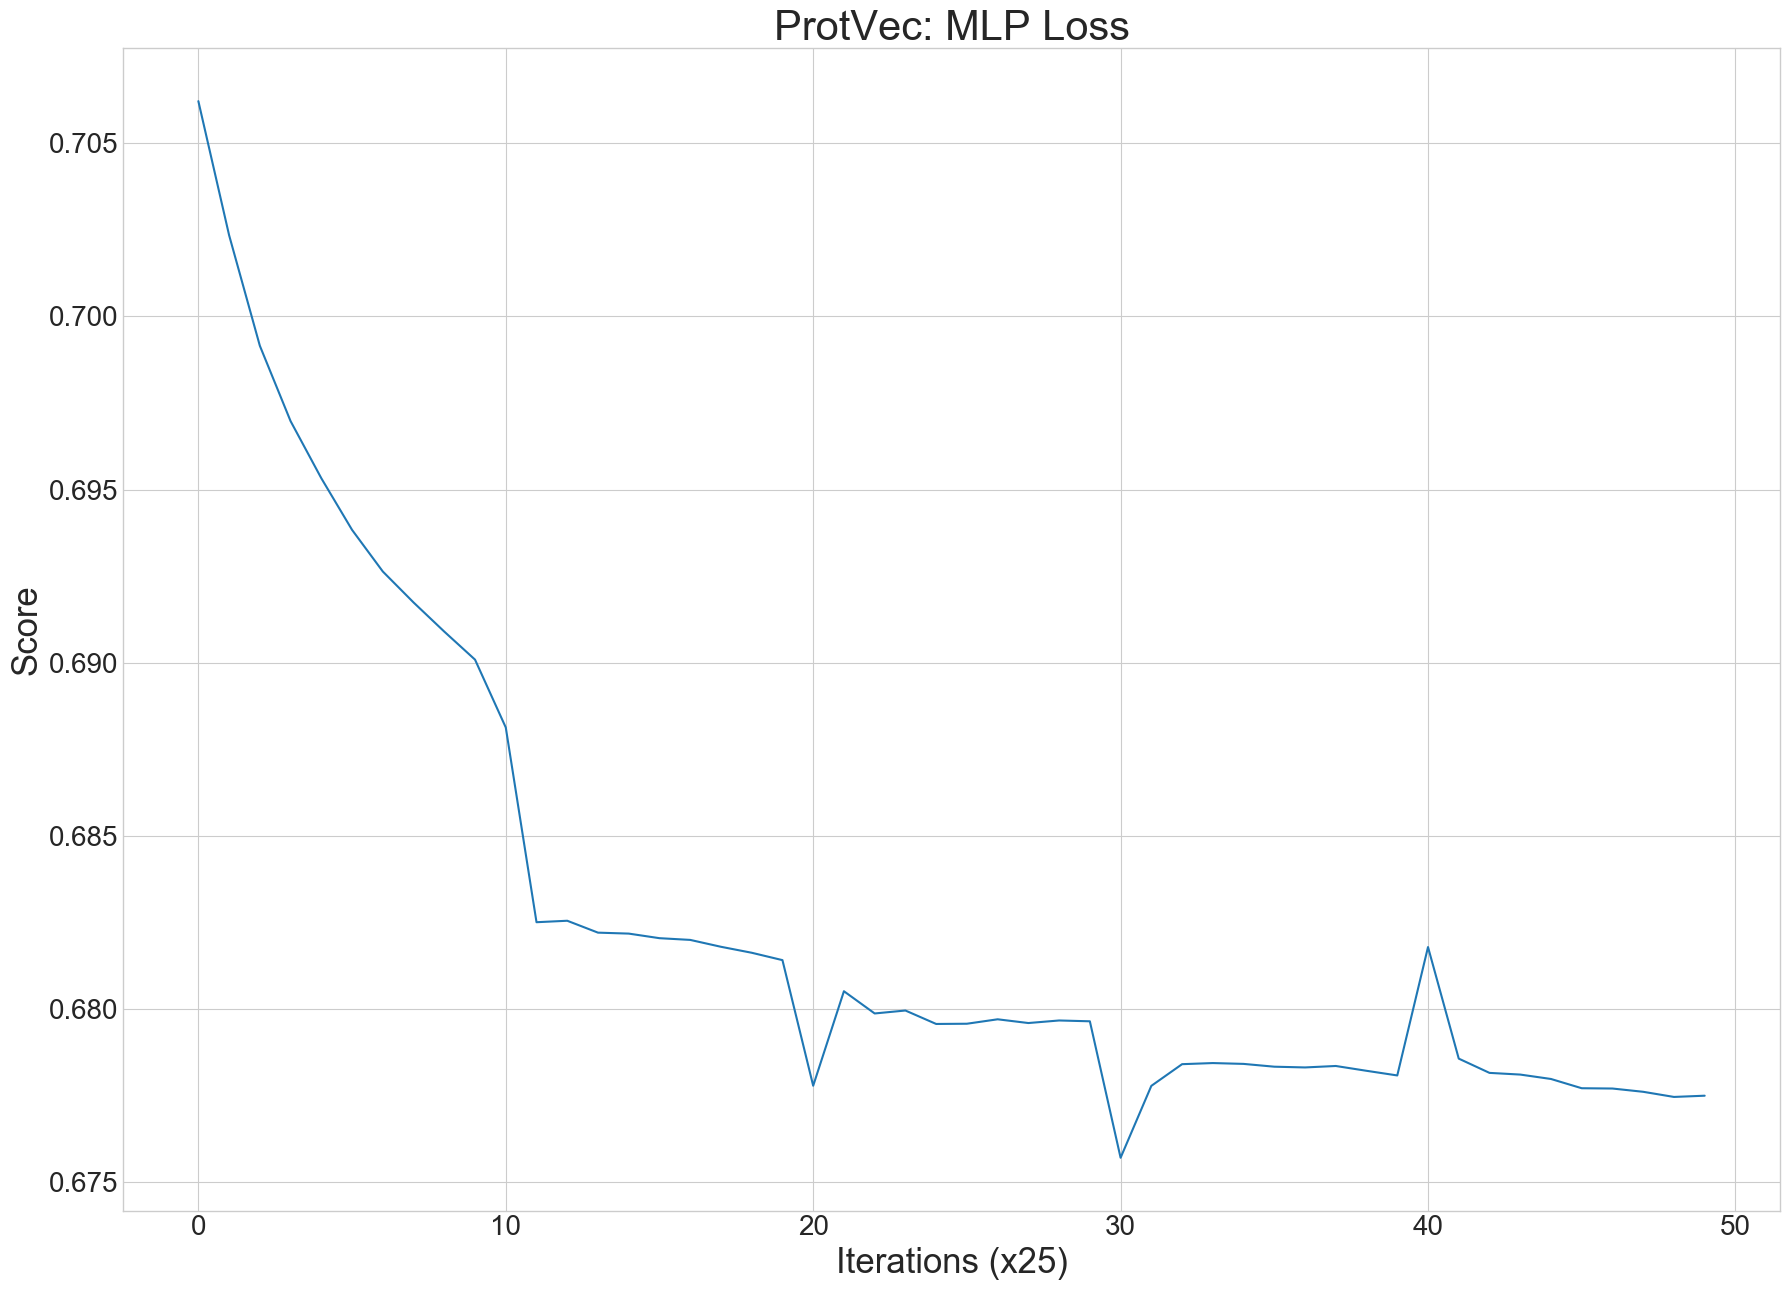

In [470]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(18,13))
plt.title("ProtVec: MLP Loss",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Iterations (x25)', fontsize=25)
plt.ylabel('Score', fontsize=25)
plt.plot(avg_losses)
# plt.plot(avg_acc_history)
plt.tight_layout()
# plt.savefig("RNN_3_loss")

In [471]:
avg_accuracy = sum(all_accuracy)/ len(all_accuracy)
avg_accuracy

0.553422619047619

In [472]:
for i in range(len(fams)):
    for j in range(len(fams)):
        if confusion[i][j]==0:
            confusion[i][j]=0.0000001

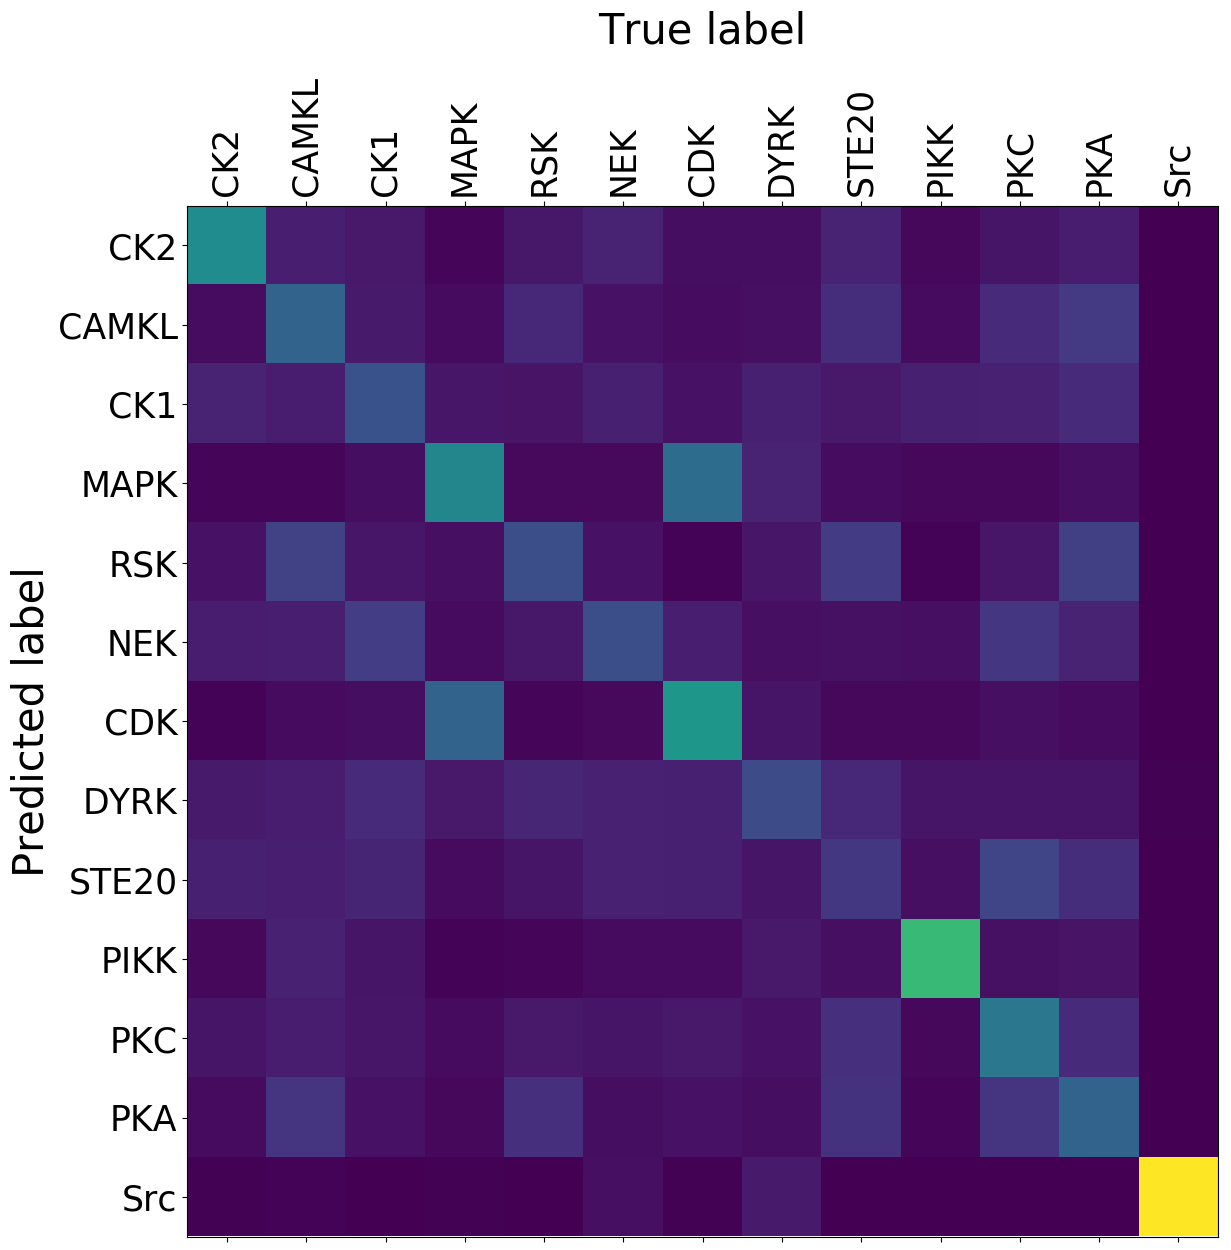

In [473]:
# Normalize by dividing every row by its sum
plt.style.use('default')
for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
# for i in range(len(fams)):
#     for j in range(len(fams)):
#         if math.isnan(confusion[i][j]) or confusion[i][j]==0:
#             confusion[i][j]=0

# Set up plot
fig = plt.figure(figsize=(12.5,12.5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)

# Set up axes
fs = [x for x in fams]
ax.set_xticklabels([''] + fs, rotation=90)
ax.set_yticklabels([''] + fs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# plt.title("RNN: Confusion matrix",fontsize=30,y=1.15)
plt.title("True label",fontsize=30,y=1.15)
plt.ylabel("Predicted label",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("poooo")


# sphinx_gallery_thumbnail_number = 2
plt.show()

In [474]:
y_test = []
for res in all_y_test:
    y_test.extend([x for x in res])

y_test = numpy.array(y_test)

y_score = []
for res in all_y_score:
    y_score.extend([x for x in res])

y_score = numpy.array(y_score)

In [475]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.49


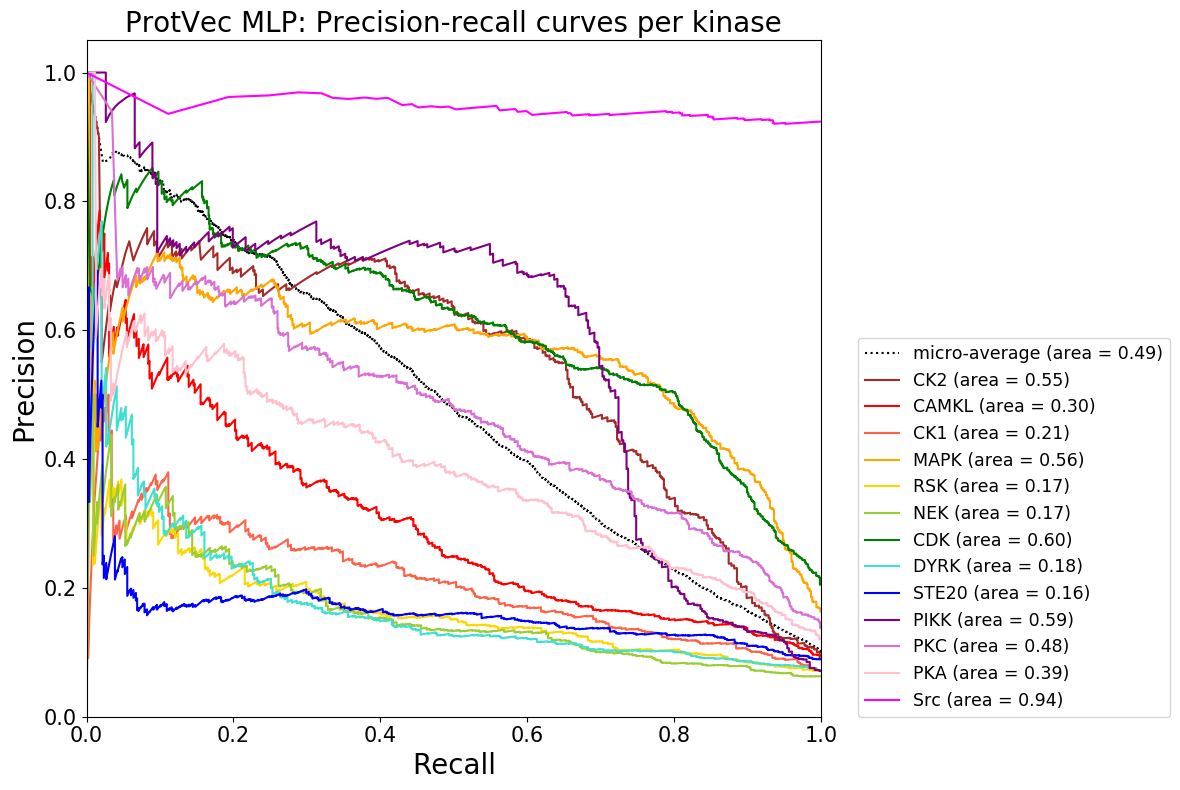

In [476]:
from itertools import cycle
import numpy as np
plt.style.use('default')

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
               'purple','pink','orchid']) 

colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

plt.figure(figsize=(12, 8))
f_scores = numpy.linspace(0.2, 0.8, num=4)
lines = []
labels = []

l, = plt.plot(recall["micro"], precision["micro"], color='black', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(fclass, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ProtVec MLP: Precision-recall curves per kinase',fontsize=20)
plt.legend(lines, labels, loc=(1.05, 0), fontsize=12.5)
plt.tight_layout()
plt.savefig("poo")

plt.show()

In [477]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

FAM_IDC = range(len(fams))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

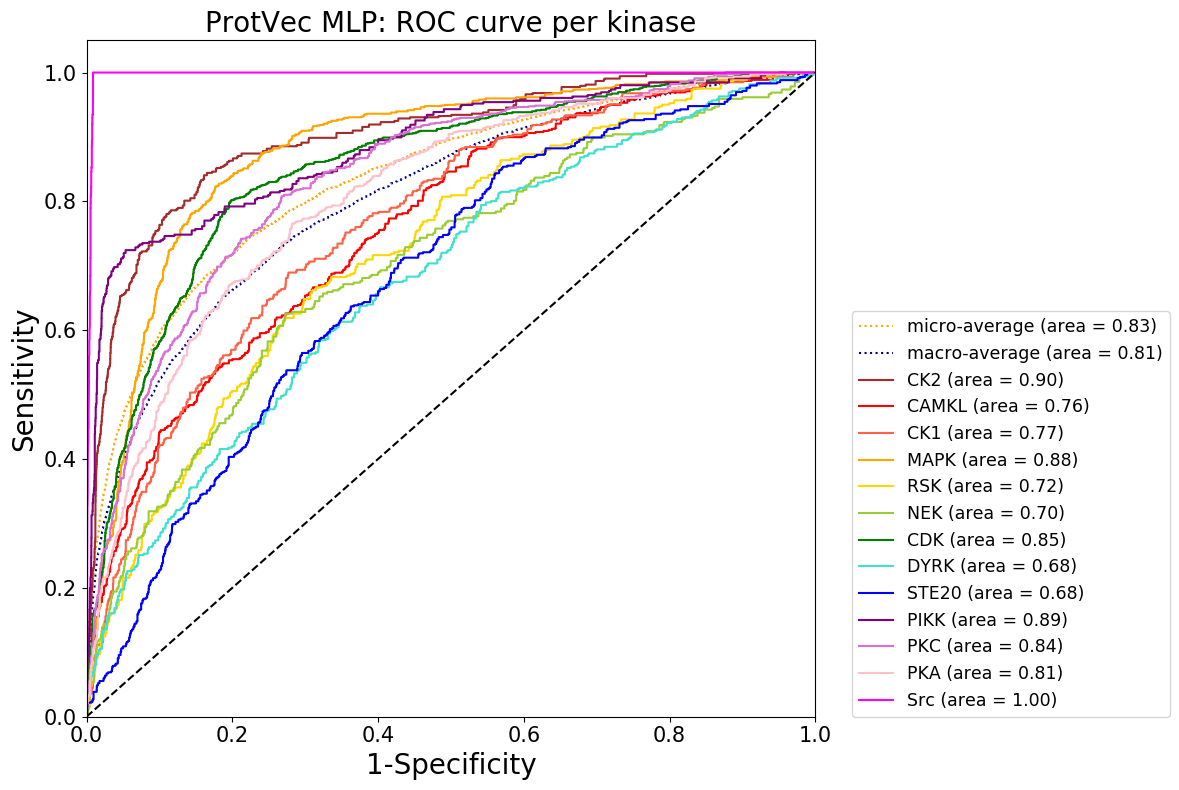

In [478]:
# Plot all ROC curves


lw = 1.5
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

for i, color in zip( (FAM_IDC), colors):
    fam = fams[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(fam, roc_auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ProtVec MLP: ROC curve per kinase',fontsize=20)
plt.legend(loc=(1.05, 0),fontsize=12.5)
plt.tight_layout()


# plt.savefig('fams_Stat_figs/RNN_ROC_select_testData_200OrMoreMotifs', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig("POOP")
plt.show()

In [479]:
confusion_numpy = confusion.detach().numpy()
FP = confusion_numpy.sum(axis=0) - np.diag(confusion_numpy)  
FN = confusion_numpy.sum(axis=1) - np.diag(confusion_numpy)
TP = np.diag(confusion_numpy)
TN = confusion_numpy.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print ("TPR:",numpy.mean(TPR))
print ("TNR:",numpy.mean(TNR)) 
print ("PPV:",numpy.mean(PPV)) 
print ("NPV:",numpy.mean(NPV)) 
print ("FPR:",numpy.mean(FPR)) 
print ("FNR:",numpy.mean(FNR)) 
print ("FDR:",numpy.mean(FDR)) 
print ("ACC:",numpy.mean(ACC)) 

TPR: 0.3569565
TNR: 0.9464131
PPV: 0.36572784
NPV: 0.94639623
FPR: 0.053586956
FNR: 0.6430435
FDR: 0.6342722
ACC: 0.9010703
